In [1]:
#import libraries
import streamlit as st

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time, date, datetime
from thefuzz import fuzz
import openpyxl
from openpyxl import Workbook

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Instruction
1. Jump to "Data Wrangling" function

## A. Data Cleaning

**Raw CFU** file is a template. To write a function:
- skiprows=2
- key: 'Batch' col
- features: [Sample description],'Storage form','Temperature (C)','T0','Date','CFU/mL','CFU/g','CV' (?),'Water Acitivty' cols
- remove rows with NaN in 'Batch' col
- Change 'Batch' col to 'FD Run ID'

- Change to datetime for "Date, T0"
- Change to float/number for "CFU/mL, CFU/g, CV": fix DIV/0 to NaN

In [180]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="/Users/miu/IFF_st/Data files/InPack_CFU_Test.csv")
rawcfu_df.head()

,"Sparkle PIVOT Sample CFU plating data recording sheet. Manually enter your data in columns marked with a ⭐ (optional: †) and the other columns should auto-calculate appropriately. The data are sortable, and can be filtered using the dropdowns in each column.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,⭐,⭐,†,†,†,⭐,†,⭐,NaN,⭐,...,⭐,⭐,†,NaN,NaN,NaN,NaN,NaN,NaN,⭐
1,Batch,Sample Description,Storage form,Temperature-Celsius,Logs,No. Reps,Extra,grams,mL,Who,...,R1,R2,R3,CFU/mL,SD CFU/mL,CFU/g,SD CFU/g,CV,Water Activity,Remark/AW
2,IFF09152022-2 T1,NaN,NaN,21,"5, 6",3,NaN,0.3,5.7,EC,...,181,203,172,7.41E+08,6.38E+07,1.41E+10,1.21E+09,8.60%,0.254,"SP-SDS, Water Activity= 0.254"
3,IFF09152022-2 T2,NaN,NaN,21,"5, 6",3,NaN,0.3,5.7,EC,...,55,47,46,1.97E+09,1.97E+08,3.75E+10,3.75E+09,10.00%,0.198,"SP-SDS, Water Activity= 0.198"
4,IFF09152022-2 T3,NaN,NaN,4,"6, 7",3,NaN,0.3,5.7,EC,...,35,24,35,1.25E+10,2.54E+09,2.38E+11,4.83E+10,20.30%,NaN,Redo


In [181]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]

# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]

# reset index, drop the orginal index col
rawcfu_df = rawcfu_df.reset_index(drop = True)

# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                       'T0','Date','CFU/mL','CFU/g','CV','Water Activity']]

rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,1/5/23,2/27/23,7.41E+08,1.41E+10,8.60%,0.254
1,IFF09152022-2 T2,NaN,NaN,21,1/5/23,2/27/23,1.97E+09,3.75E+10,10.00%,0.198
2,IFF09152022-2 T3,NaN,NaN,4,1/5/23,2/27/23,1.25E+10,2.38E+11,20.30%,NaN
3,IFF09152022-2 T3,NaN,NaN,4,1/5/23,3/1/23,2.30E+01,4.50E+00,8.60%,NaN
4,IFF09152022-2 T4,NaN,NaN,21,1/5/23,2/27/23,4.55E+08,8.64E+09,7.90%,0.267


In [182]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                67 non-null     object
 1   Sample Description   8 non-null      object
 2   Storage form         23 non-null     object
 3   Temperature-Celsius  17 non-null     object
 4   T0                   67 non-null     object
 5   Date                 67 non-null     object
 6   CFU/mL               71 non-null     object
 7   CFU/g                67 non-null     object
 8   CV                   67 non-null     object
 9   Water Activity       14 non-null     object
dtypes: object(10)
memory usage: 5.7+ KB


<AxesSubplot:xlabel='1'>

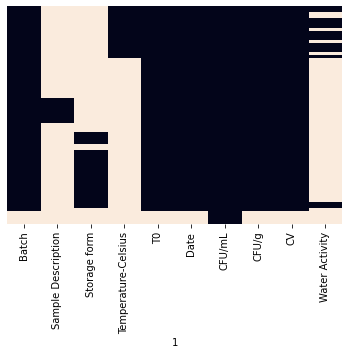

In [183]:
# check NaN values
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

(401, 10)

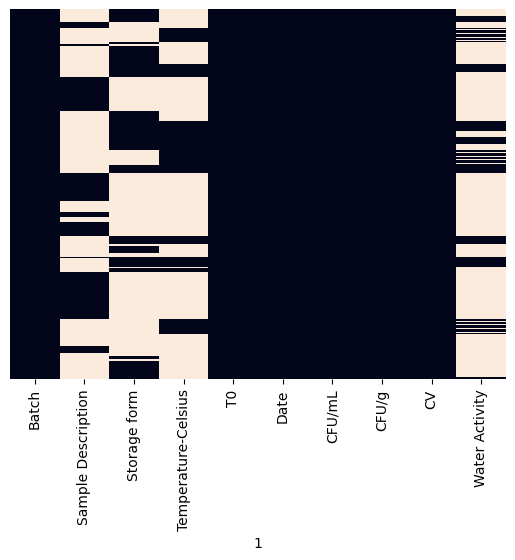

In [6]:
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)
rawcfu_df.shape

# NaN in CFU/mL or CFU/g indicate either the samples in liq or sol form

In [7]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                401 non-null    object
 1   Sample Description   154 non-null    object
 2   Storage form         157 non-null    object
 3   Temperature-Celsius  128 non-null    object
 4   T0                   401 non-null    object
 5   Date                 401 non-null    object
 6   CFU/mL               401 non-null    object
 7   CFU/g                401 non-null    object
 8   CV                   401 non-null    object
 9   Water Activity       101 non-null    object
dtypes: object(10)
memory usage: 34.5+ KB


In [184]:
# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

In [185]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.41E+08,1.41E+10,8.60%,0.254
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.97E+09,3.75E+10,10.00%,0.198
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.25E+10,2.38E+11,20.30%,NaN
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.30E+01,4.50E+00,8.60%,NaN
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.55E+08,8.64E+09,7.90%,0.267


In [186]:
# calculate the time point of plating
## the difference 'Date'-'T0' is a 'timedelta'
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.41E+08,1.41E+10,8.60%,0.254,53.0
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.97E+09,3.75E+10,10.00%,0.198,53.0
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.25E+10,2.38E+11,20.30%,NaN,53.0
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.30E+01,4.50E+00,8.60%,NaN,55.0
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.55E+08,8.64E+09,7.90%,0.267,53.0


In [187]:
# calculate time point in week
## cant' call .days or .week on timedelta. 
## So, I have to convert each dat to week of the year first before calculating the difference
to_week = rawcfu_df[['T0','Date']]

In [12]:
rawcfu_df['Date'].iloc[0].week - rawcfu_df['T0'].iloc[0].week

0

In [13]:
to_week.columns

Index(['T0', 'Date'], dtype='object', name=1)

In [188]:
for i in to_week.columns:
    to_week[i] = to_week[i].apply(lambda x:x.week)

In [189]:
rawcfu_df['Time point (week)'] = to_week['Date'] - to_week['T0']

In [190]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.41E+08,1.41E+10,8.60%,0.254,53.0,8.0
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.97E+09,3.75E+10,10.00%,0.198,53.0,8.0
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.25E+10,2.38E+11,20.30%,NaN,53.0,8.0
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.30E+01,4.50E+00,8.60%,NaN,55.0,8.0
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.55E+08,8.64E+09,7.90%,0.267,53.0,8.0


In [ ]:
# Change data type of CFU/mL 
rawcfu_df['CFU/mL'] = rawcfu_df['CFU/mL'].astype(float)

In [192]:
# invalid values (not scientific) in CFU/g col
rawcfu_df.loc[rawcfu_df['CFU/g'] == '#DIV/0!'].index

Int64Index([], dtype='int64')

In [193]:
# replace invalid values with NaN
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].replace('#DIV/0!', np.NaN)

In [194]:
# Change data type of CFU/g to float
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].astype(float)

In [195]:
# Change data type of CV to float
## convert each value to float without the % sign and ignore invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

In [196]:
## replace invalid values with NaN
rawcfu_df['CV'] = rawcfu_df['CV'].replace('#DIV/0!', np.NaN)

In [197]:
rawcfu_df

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.41E+08,1.410000e+10,8.6,0.254,53.0,8.0
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.97E+09,3.750000e+10,10.0,0.198,53.0,8.0
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.25E+10,2.380000e+11,20.3,NaN,53.0,8.0
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.30E+01,4.500000e+00,8.6,NaN,55.0,8.0
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.55E+08,8.640000e+09,7.9,0.267,53.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
66,FD-23-0006-T3,NaN,NaN,NaN,2023-03-13,2023-03-15,1.72E+09,3.770000e+11,15.7,NaN,2.0,0.0
67,NaN,NaN,NaN,NaN,NaT,NaT,#DIV/0!,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaT,NaT,#DIV/0!,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaT,NaT,#DIV/0!,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='1'>

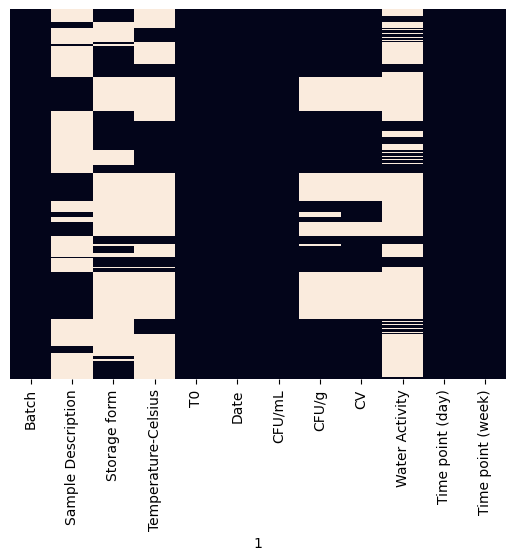

In [24]:
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

In [198]:
rawcfu_df.info()
# Keep Temp in str for visualization purpose

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Batch                67 non-null     object        
 1   Sample Description   8 non-null      object        
 2   Storage form         23 non-null     object        
 3   Temperature-Celsius  17 non-null     object        
 4   T0                   67 non-null     datetime64[ns]
 5   Date                 67 non-null     datetime64[ns]
 6   CFU/mL               71 non-null     object        
 7   CFU/g                67 non-null     float64       
 8   CV                   67 non-null     object        
 9   Water Activity       14 non-null     object        
 10  Time point (day)     67 non-null     float64       
 11  Time point (week)    67 non-null     float64       
dtypes: datetime64[ns](2), float64(3), object(7)
memory usage: 6.8+ KB


In [199]:
# Change Water Activity to float
rawcfu_df['Water Activity'] = rawcfu_df['Water Activity'].astype(float)

In [200]:
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'CV':'CV (%)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.41E+08,1.410000e+10,8.6,0.254,53.0,8.0
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.97E+09,3.750000e+10,10.0,0.198,53.0,8.0
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.25E+10,2.380000e+11,20.3,NaN,53.0,8.0
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.30E+01,4.500000e+00,8.6,NaN,55.0,8.0
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.55E+08,8.640000e+09,7.9,0.267,53.0,8.0


In [201]:
rawcfu_df.rename(columns={'Temperature (C)':'Temperature (C)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.41E+08,1.410000e+10,8.6,0.254,53.0,8.0
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.97E+09,3.750000e+10,10.0,0.198,53.0,8.0
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.25E+10,2.380000e+11,20.3,NaN,53.0,8.0
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.30E+01,4.500000e+00,8.6,NaN,55.0,8.0
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.55E+08,8.640000e+09,7.9,0.267,53.0,8.0


### Data cleaning steps

In [ ]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="/Users/miu/IFF_st/Data files/InPack_CFU_Test.csv")

In [3]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]
# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]
# reset index
rawcfu_df = rawcfu_df.reset_index(drop=True)
# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature (C)',
                       'T0','Date','CFU/mL','CFU/g','CV','Water Activity']]
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)


# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

# calculate the time point of plating
## by days
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
## by weeks   
def num_weeks(row):
        year1, week1, day1 = row['T0'].isocalendar()
        year2, week2, day2 = row['Date'].isocalendar()
        return (year2 - year1) * 52 + (week2 - week1)

# apply the function to each row of the DataFrame
rawcfu_df['Time point (week)'] = rawcfu_df.apply(num_weeks, axis=1)

# remove percentage sign for CV values while ignoring invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

# handle invalid values and change to float
to_float = rawcfu_df[['CFU/mL','CFU/g','Water Activity']]
for col in to_float.columns:
    rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
    rawcfu_df[col] = rawcfu_df[col].astype(float)
    
    
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'Temperature (C)':'Temperature (C)', 'CV':'CV (%)'}, inplace=True)

In [4]:
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
2,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-02-27,1.250000e+10,2.380000e+11,20.3,NaN,53,8
3,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
4,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [5]:
rawcfu_df.shape

(65, 12)

In [6]:
rawcfu_df['FD Run ID'].nunique()

61

## B. Data Processing

One sample can be in different storage form: bulk powder, pellet. Each will have a unique 'FD Run ID'
- **ISSUE: Naming for unique ID**
    Each 'FD Run ID' is not unique because:
    - one sample is submitted to different temperatures
    - one sample is stored in different form
- Arrange the CFU of each sample by Timepoint (week) (axis =1) (pivot table)
- Join new CFU data for each time point, axis =1
    - make sure there are only unique IDs (aka shape of pivot table)
    - remove 'T0','Date','CV' from rawcfu_df becasue it they make the some samples carry distinguish info (e.g. one sample with W0, W8 but different CV and Date -> the rows stay

In [83]:
# Record the CFUs by week for each ID
pivot_rawcfu = rawcfu_df.pivot(index='FD Run ID', columns='Time point (week)', values=['CFU/mL','CFU/g'])

In [84]:
pivot_rawcfu

CFU/mL                           CFU/g      \
Time point (week)               0   1             8             0   1   
FD Run ID                                                               
ABKLUB 030823AA      2.120000e+10 NaN           NaN  4.030000e+11 NaN   
ABKLUB 031023AA      2.250000e+10 NaN           NaN  4.280000e+11 NaN   
ABKLUB 031323AA      2.400000e+10 NaN           NaN  4.560000e+11 NaN   
ABKLUB 031623AA #9   2.960000e+10 NaN           NaN  5.620000e+11 NaN   
ABKLUB 031823AA #10  2.530000e+10 NaN           NaN  4.810000e+11 NaN   
...                           ...  ..           ...           ...  ..   
IFF10202022-1 T4              NaN NaN  7.170000e+07           NaN NaN   
IFF10202022-2 T1              NaN NaN  7.730000e+06           NaN NaN   
IFF10202022-2 T2              NaN NaN  1.050000e+07           NaN NaN   
IFF10202022-2 T3              NaN NaN  2.730000e+09           NaN NaN   
IFF10202022-2 T4              NaN NaN  4.130000e+06           NaN NaN   

                                   
Time point (week)               8  
FD Run ID                          
ABKLUB 030823AA               NaN  
ABKLUB 031023AA               NaN  
ABKLUB 031323AA               NaN  
ABKLUB 031623AA #9            NaN  
ABKLUB 031823AA #10           NaN  
...                           ...  
IFF10202022-1 T4     1.360000e+09  
IFF10202022-2 T1     1.470000e+08  
IFF10202022-2 T2     2.000000e+08  
IFF10202022-2 T3     5.190000e+10  
IFF10202022-2 T4     7.850000e+07  

[61 rows x 6 columns]

In [ ]:
# write to excel. Gives expected format
pivot_rawcfu.to_excel('CFU_cleaned.xlsx')

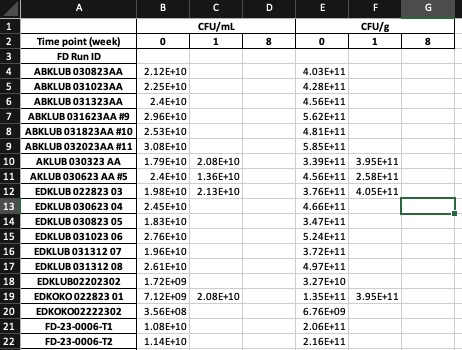

In [28]:
pivot_rawcfu.loc['AKLUB 030323 AA']

        Time point (week)
CFU/mL  0                    1.790000e+10
        1                    2.080000e+10
        8                             NaN
CFU/g   0                    3.390000e+11
        1                    3.950000e+11
        8                             NaN
Name: AKLUB 030323 AA, dtype: float64

In [29]:
pivot_rawcfu.columns.to_list()

[('CFU/mL', 0),
 ('CFU/mL', 1),
 ('CFU/mL', 8),
 ('CFU/g', 0),
 ('CFU/g', 1),
 ('CFU/g', 8)]

In [85]:
# rename the column by the counting week
pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]

In [100]:
# remove cols that cause repeated samples
cfu = rawcfu_df.drop(['T0','Date','CFU/mL','CFU/g','CV (%)','Time point (day)','Time point (week)'],axis=1)

In [101]:
cfu.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity
0,IFF09152022-2 T1,NaN,NaN,21,0.254
1,IFF09152022-2 T2,NaN,NaN,21,0.198
2,IFF09152022-2 T3,NaN,NaN,4,NaN
3,IFF09152022-2 T4,NaN,NaN,21,0.267
4,IFF09152022-3 T1,NaN,NaN,21,0.227


In [102]:
cfu.shape, pivot_rawcfu.shape

((65, 5), (61, 6))

In [103]:
cfu[cfu.duplicated('FD Run ID')]

1,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity
25,AKLUB 030623 AA #5,NaN,NaN,NaN,NaN
26,AKLUB 030323 AA,NaN,NaN,NaN,NaN
27,EDKOKO 022823 01,NaN,NaN,NaN,NaN
28,EDKLUB 022823 03,NaN,NaN,NaN,NaN


In [104]:
cfu.drop_duplicates(subset='FD Run ID', inplace=True)

In [105]:
cfu.shape

(61, 5)

In [106]:
joined_df = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')

In [107]:
joined_df.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g
0,IFF09152022-2 T1,NaN,NaN,21,0.254,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10
1,IFF09152022-2 T2,NaN,NaN,21,0.198,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10
2,IFF09152022-2 T3,NaN,NaN,4,NaN,NaN,NaN,1.250000e+10,NaN,NaN,2.380000e+11
3,IFF09152022-2 T4,NaN,NaN,21,0.267,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09
4,IFF09152022-3 T1,NaN,NaN,21,0.227,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09


In [108]:
joined_df.shape

(61, 11)

In [109]:
rawcfu_df.shape, pivot_rawcfu.shape, joined_df.shape

((65, 12), (61, 6), (61, 11))

The key information from this table is:
- FD Run ID: these must be unique and implemented soon for the program to work properly
- CFUs by weeks 

It's possible for the CFUs data to collected in 1 file as the df will be replaced and updated each time. The code will work as expected without concatenating the new info. 

The next steps are to:
- join this table to the master list
- relate to on-seed samples
- relate to sample information sheet (?)

### Data Processing Step

In [7]:
# Record the CFUs by week for each ID
pivot_rawcfu = rawcfu_df.pivot(index='FD Run ID', columns='Time point (week)', values=['CFU/mL','CFU/g'])
# rename the column by the counting week
pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]

# remove cols that cause repeated samples
cfu = rawcfu_df.drop(['T0','Date','CFU/mL','CFU/g','CV (%)','Time point (day)','Time point (week)'],axis=1)
# drop duplicated IDs
cfu.drop_duplicates(subset='FD Run ID', inplace=True)

# join the pivot df with the original info
cleaned_cfu = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')

In [8]:
cleaned_cfu.head()

,FD Run ID,Sample Description,Storage form,Temperature (C),Water Activity,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g
0,IFF09152022-2 T1,NaN,NaN,21,0.254,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10
1,IFF09152022-2 T2,NaN,NaN,21,0.198,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10
2,IFF09152022-2 T3,NaN,NaN,4,NaN,NaN,NaN,1.250000e+10,NaN,NaN,2.380000e+11
3,IFF09152022-2 T4,NaN,NaN,21,0.267,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09
4,IFF09152022-3 T1,NaN,NaN,21,0.227,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09


In [9]:
cleaned_cfu.shape

(61, 11)

In [ ]:
cleaned_cfu.to_excel('CFU_cleaned.xlsx')

## Data Wrangling Function

In [2]:
def pivot_in_pack(df):
    rawcfu_df = df
    rawcfu_df.columns = rawcfu_df.iloc[1]
    rawcfu_df = rawcfu_df.iloc[2:]
    rawcfu_df = rawcfu_df.reset_index(drop = True) # drop the original index
    # remove rows with NaN in 'Batch" col
    rawcfu_df.dropna(subset=['Batch'],inplace=True)
    # remove rows with 'Redo' in 'Remark' col
    rawcfu_df.drop(rawcfu_df[rawcfu_df['Remark/AW'] == 'Redo'].index, inplace=True)
    # keep relevant cols
    rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                           'T0','Date','CFU/mL','CFU/g', 'CV','Water Activity']]
    
    # convert to datetime for T0 and Date
    rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")
    
    # calculate the time point by days and weeks of plating
    ## by days
    rawcfu_df['Day'] = np.absolute((rawcfu_df['Date']-rawcfu_df['T0'])).apply(lambda x: x.days)
    ## by weeks
    #df['Time point (week)'] = df['T0'].apply(lambda x: x.week) - df['Date'].apply(lambda x: x.week)
    def num_weeks(row):
        year1, week1, day1 = row['T0'].isocalendar()
        year2, week2, day2 = row['Date'].isocalendar()
        return (year2 - year1) * 52 + (week2 - week1)

    # apply the function to each row of the DataFrame
    rawcfu_df['Week'] = rawcfu_df.apply(num_weeks, axis=1)    
    
    # remove percentage sign for CV values while ignoring invalid values
    for idx, row in rawcfu_df.iterrows():
        try:
            rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
        except Exception as e:
            pass
    
    # handle invalid values and change to float
    to_float = rawcfu_df[['CFU/mL','CFU/g','Water Activity']]
    for col in to_float.columns:
        rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
        rawcfu_df[col] = rawcfu_df[col].astype(float)      
        
    # change col names
    rawcfu_df.rename(columns={'Batch':'FD Run ID', 'CV':'CV (%)'}, inplace=True)
    #rawcfu_df = rawcfu_df.reset_index(drop=True)
    
    # Record the CFUs by week for each ID
    pivot_rawcfu = rawcfu_df.pivot(
        index='FD Run ID', columns='Week',
        values=['CFU/mL','CFU/g','Water Activity'])
    # rename the column by the counting week
    pivot_rawcfu.columns = [f"W{week}_{scale}" for scale, week in pivot_rawcfu.columns.to_list()]
    
    # remove cols that cause repeated samples
    cfu = rawcfu_df.drop(['Sample Description','Storage form','Temperature-Celsius',
                          'CFU/mL','CFU/g','CV (%)','Water Activity','Day','Week'],axis=1)
    # drop duplicated IDs
    cfu.drop_duplicates(subset='FD Run ID', inplace=True)
    
    # join the pivot df with the original info
    cleaned_cfu = pd.merge(cfu, pivot_rawcfu, on='FD Run ID')
    
    return rawcfu_df, cleaned_cfu

In [3]:
# Import the dataset
data = pd.read_csv(filepath_or_buffer="/Users/miu/IFF_st/Data files/InPack_CFU_Test.csv")

In [4]:
raw, clean = pivot_in_pack(data)

In [5]:
clean.head()

,FD Run ID,T0,Date,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity
0,IFF09152022-2 T1,2023-01-05,2023-02-27,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10,NaN,NaN,0.254
1,IFF09152022-2 T2,2023-01-05,2023-02-27,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10,NaN,NaN,0.198
2,IFF09152022-2 T3,2023-01-05,2023-03-01,NaN,NaN,2.300000e+01,NaN,NaN,4.500000e+00,NaN,NaN,NaN
3,IFF09152022-2 T4,2023-01-05,2023-02-27,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09,NaN,NaN,0.267
4,IFF09152022-3 T1,2023-01-05,2023-02-27,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09,NaN,NaN,0.227


In [6]:
clean.columns

Index(['FD Run ID', 'T0', 'Date', 'W0_CFU/mL', 'W1_CFU/mL', 'W8_CFU/mL',
       'W0_CFU/g', 'W1_CFU/g', 'W8_CFU/g', 'W0_Water Activity',
       'W1_Water Activity', 'W8_Water Activity'],
      dtype='object')

In [7]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FD Run ID          61 non-null     object        
 1   T0                 61 non-null     datetime64[ns]
 2   Date               61 non-null     datetime64[ns]
 3   W0_CFU/mL          45 non-null     float64       
 4   W1_CFU/mL          4 non-null      float64       
 5   W8_CFU/mL          16 non-null     float64       
 6   W0_CFU/g           45 non-null     float64       
 7   W1_CFU/g           4 non-null      float64       
 8   W8_CFU/g           16 non-null     float64       
 9   W0_Water Activity  2 non-null      float64       
 10  W1_Water Activity  0 non-null      float64       
 11  W8_Water Activity  12 non-null     float64       
dtypes: datetime64[ns](2), float64(9), object(1)
memory usage: 6.2+ KB


In [8]:
def remove_spaces(df):
    """
    This function removes the spaces before and after a string. 
    The function will pass columns with timestamp and numerical datatypes
    """
    for col in df:
        if df[col].dtype == np.dtype('object'):
        
            df[col] = df[col].apply(lambda x:x.strip() if type(x) == "str" else x)
    return df

In [ ]:
clean.to_csv('clean_inpack.csv',index=False)

In [9]:
raw.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Day,Week
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.300000e+01,4.500000e+00,8.6,NaN,55,8
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
5,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [10]:
raw.shape, clean.shape

((65, 12), (61, 12))

## C. Decay Rate Analysis

Decay rate calculation uses LINEST function.<br>
The two variables are time_day (x) and log10_CFU (y).

Use `raw` df to [transform] calculate the decay rate and fit the data

---

**Unit test**

Use the `inpack_df` values to test whether scikit linear regression (or statsmodel) produces the same value

In [11]:
inpack_df = pd.read_excel("/Users/miu/IFF_st/Data files/PIVOT Sample Master List 2023_10May23.xlsm", sheet_name='WP4 In-pack Data')

In [12]:
inpack_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unique ID', 'FD sample ID', 'FD Run ID', 'Strain', 'Cryo mix',
       'Sub-Sample', 'Ferm Condition', 'Storage form', 'Temperature (°C)',
       'Container', 'Bulking', 'Desiccant', 'Quantity (g)', 'Sample location',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],
      dtype='object')>

In [13]:
# The final output to achieve
decay_output = inpack_df[['FD Run ID','Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g','Week 12 CFU/g',
                       'decay_rate_fitted', 'Rsquared_fitted','decay_rate_errbar', 'decay_rate_lower95interval',
                        'decay_rate_upper95interval', 'estimate_day_2e10']]

In [14]:
decay_output.head()

,FD Run ID,Week 0 CFU/g,Week 2 CFU/g,Week 4 CFU/g,Week 8 CFU/g,Week 12 CFU/g,decay_rate_fitted,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10
0,FDL-099A,4.053333e+11,NaN,2.584000e+11,1.490000e+11,NaN,-0.007761,0.996659,0.000881,-0.008642,-0.006880,168.374192
1,FDL-099A,4.053333e+11,NaN,2.698000e+11,9.500000e+10,NaN,-0.011252,0.939662,0.005588,-0.016840,-0.005663,116.142074
2,FDL-099A,4.002667e+11,NaN,1.774600e+11,5.624000e+10,NaN,-0.015220,0.990339,0.002946,-0.018166,-0.012273,85.502213
3,FDL-099A,1.856933e+11,NaN,1.014600e+11,4.522000e+10,NaN,-0.010955,0.993116,0.001788,-0.012742,-0.009167,88.342199
4,FDL-099A,2.381333e+11,NaN,9.918000e+10,3.648000e+10,NaN,-0.014549,0.998539,0.001091,-0.015640,-0.013459,73.940614


In [15]:
to_cal_decay = decay_output.copy()

In [16]:
to_cal_decay.rename(columns={'Week 0 CFU/g':'0', 'Week 2 CFU/g':'14', 'Week 4 CFU/g':'28',
                           'Week 8 CFU/g':'56','Week 12 CFU/g':'84'}, inplace=True)

to_cal_decay = to_cal_decay[['FD Run ID','0','14','28','56','84']]

In [17]:
to_cal_decay.head()

,FD Run ID,0,14,28,56,84
0,FDL-099A,4.053333e+11,NaN,2.584000e+11,1.490000e+11,NaN
1,FDL-099A,4.053333e+11,NaN,2.698000e+11,9.500000e+10,NaN
2,FDL-099A,4.002667e+11,NaN,1.774600e+11,5.624000e+10,NaN
3,FDL-099A,1.856933e+11,NaN,1.014600e+11,4.522000e+10,NaN
4,FDL-099A,2.381333e+11,NaN,9.918000e+10,3.648000e+10,NaN


In [18]:
to_cal_decay.shape

(187, 6)

In [19]:
to_cal_decay['FD Run ID'].nunique()

91

In [ ]:
to_cal_decay['FD Run ID'].unique().tolist()

In [20]:
id_to_test=['FDL-105EF-T24-CC1',
 'FDL-105EF-T24-CC2',
 'FDL-105EF-T24-SO1',
 'FDL-105EF-T24-SO2',
 'FDL-105EF-T24-TMC1',
 'FDL-105EF-T24-TMC2',
 'FDL-105B-T10-CC1',
 'FDL-105B-T10-CC2',
 'FDL-105EF-T26-CC1',
 'FDL-105EF-T26-CC2',
 'FDL-105EF-T26-TMC1',
 'FDL-105EF-T26-TMC2',
 'FDL-105EF-T26-SO1',
 'FDL-105EF-T26-SO2',
 'FDL-105EF-T22-Try',
 'FDL-105EF-T24-SKP',
 'FDL-105C-T15-SKP',
 'FDL-105C-T15-Try',
 'FDL-105C-T14-Try',
 'FDL-105D-T20-Try',
 'FDL-105G-T33-Try',
 'FDL-111EF-T18 ',
 'FDL-111EF-T18-CC1TMC1',
 'FDL-111EF-T18-TMC1',
 'FDL-111EF-T19',
 'FDL-111EF-T19-CC1TMC1',
 'FDL-111EF-T19-TMC1',
 'FDL-111G-T22',
 'FDL-111G-T22-CC1TMC1',
 'FDL-111G-T22-TMC1',
 'FDL-111G-T23 ',
 'FDL-111G-T23-CC1TMC1',
 'FDL-111G-T23-TMC1',
 'FDL-111A-T2',
 'FDL-111A-T2-TMC1',
 'FDL-111A-T2-TMC2',
 'FDL-111A-T3',
 'FDL-111A-T3-TMC1',
 'FDL-111A-T3-TMC2',
 'FDL-111A-T4',
 'FDL-111A-T4-TMC1',
 'FDL-111A-T4-TMC2',
 'FDL-111B-T8-CC1',
 'FDL-111B-T8-TMC1',
 'FDL-111B-T8',
 'FDL-111D-T14-CC1',
 'FDL-111D-T14-TMC1',
 'FDL-111D-T14',
 'FDL-111D-T15-CC1',
 'FDL-111D-T15-TMC1',
 'FDL-111D-T15',
 'FDL-105K-T42',
 'FDL-105K-T44',
 'FDL-111G T23 TMC1',
 'FDL-105B-T10-SKP',
 'FDL-105B-T10-Try']

**List of df:**
1. to_cal_decay: (wide format) include all ids, NaNs, duplicates
2. **to_unpivot**: (wide format) df to concatenate with results later. 
    - It is the **clean** df without T0, Date cols
3. unpivot: (long format) melted df <br>
    a. remove NaN values interfering calculation <br>
    b. remove duplicates 
    - It is the **raw** df
4. **grouped_ids**: (long format) containing the decay_rate, r-squared, CI

    - wide format: contains values that don't repeat in first col
    - long format: contains values that repeat in first col
    
5. **decay_final**: join the **to_unpivot** and **grouped_ids** 

In [21]:
to_unpivot = to_cal_decay[to_cal_decay['FD Run ID'].isin(id_to_test)]

In [22]:
to_unpivot = remove_spaces(to_unpivot)

In [23]:
to_unpivot.head()

,FD Run ID,0,14,28,56,84
119,FDL-105EF-T24-CC1,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN
120,FDL-105EF-T24-CC2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN
121,FDL-105EF-T24-SO1,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN
122,FDL-105EF-T24-SO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN
123,FDL-105EF-T24-TMC1,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN


In [24]:
to_cal_decay.shape, to_unpivot.shape

((187, 6), (67, 6))

In [25]:
to_unpivot[to_unpivot['FD Run ID']=='FDL-105B-T10-CC1']

,FD Run ID,0,14,28,56,84
125,FDL-105B-T10-CC1,1.260333e+11,1.026000e+11,8.191111e+10,NaN,NaN


In [26]:
unpivot_df = pd.melt(to_unpivot, id_vars=['FD Run ID'], var_name=['Day'],value_name='CFU/g')

In [27]:
unpivot_df

,FD Run ID,Day,CFU/g
0,FDL-105EF-T24-CC1,0,1.133667e+11
1,FDL-105EF-T24-CC2,0,1.222333e+11
2,FDL-105EF-T24-SO1,0,1.133667e+11
3,FDL-105EF-T24-SO2,0,1.222333e+11
4,FDL-105EF-T24-TMC1,0,1.133667e+11
...,...,...,...
330,FDL-111G-T22-CC1TMC1,84,NaN
331,FDL-111G-T22-TMC1,84,NaN
332,FDL-111G-T23,84,NaN
333,FDL-111G-T23-CC1TMC1,84,NaN


In [28]:
unpivot_df.shape

(335, 3)

<AxesSubplot:>

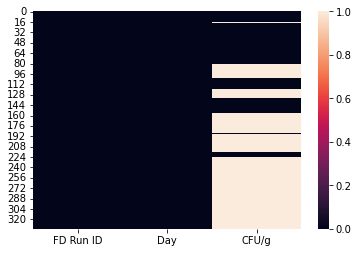

In [29]:
sns.heatmap(unpivot_df.isnull())

In [30]:
# Drop NaN values as they will throw errors in running the model
unpivot_df.dropna(subset=['FD Run ID','CFU/g'], inplace=True)

In [31]:
unpivot_df.shape

(129, 3)

In [32]:
# Drop the duplicates values (if any from human data entry error)
unpivot_df.drop_duplicates(subset=['FD Run ID','Day','CFU/g'], inplace=True)

In [33]:
unpivot_df.shape

(118, 3)

In [34]:
unpivot_df['LogCFU'] = np.log10(unpivot_df['CFU/g'])

In [35]:
unpivot_df.head()

,FD Run ID,Day,CFU/g,LogCFU
0,FDL-105EF-T24-CC1,0,1.133667e+11,11.054485
1,FDL-105EF-T24-CC2,0,1.222333e+11,11.087190
2,FDL-105EF-T24-SO1,0,1.133667e+11,11.054485
3,FDL-105EF-T24-SO2,0,1.222333e+11,11.087190
4,FDL-105EF-T24-TMC1,0,1.133667e+11,11.054485


### C1. Use Linear Regression

Unit test

In [36]:
a = unpivot_df[unpivot_df['FD Run ID']=='FDL-105B-T10-CC1']

In [37]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28,8.191111e+10,10.913343


In [38]:
b = unpivot_df[unpivot_df['FD Run ID']=='FDL-111A-T2-TMC1']

In [39]:
b

,FD Run ID,Day,CFU/g,LogCFU
36,FDL-111A-T2-TMC1,0,1.257800e+10,10.099612
103,FDL-111A-T2-TMC1,14,1.869600e+09,9.271749


In [40]:
model = LinearRegression()

In [41]:
X_a = a['Day'].values.reshape(-1,1)
y_a = a['LogCFU'].values

In [42]:
X_b = b['Day'].values.reshape(-1,1)
y_b = b['LogCFU'].values

In [43]:
model_a = model.fit(X_a, y_a)

In [44]:
model_a.coef_

array([-0.00668366])

In [45]:
model_b = model.fit(X_b, y_b)
model_b.coef_[0]

-0.05913306364345417

Confirmed the coef (or slope) is the same as the decay_out df

In [46]:
a['Day'] = a['Day'].astype('float64')

In [47]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0.0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14.0,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28.0,8.191111e+10,10.913343


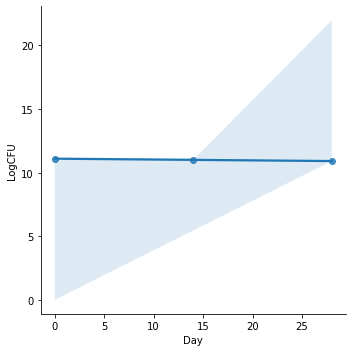

In [48]:
# provide 95%CI grpah
sns.lmplot(x='Day', y='LogCFU', data=a, fit_reg=True, ci=95, n_boot=1000)

---
Unit test (cont)

In [49]:
def fit_linear_regression(df):
    X = df['Day'].values.reshape(-1,1)
    y = df['LogCFU'].values

    model = LinearRegression()
    model.fit(X,y)
    
    decay_rate = model.coef_[0]
    r_squared = model.score(X, y)
    
    return pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})

In [ ]:
y = weight (day) * day + b

In [50]:
grouped_ids = unpivot_df.groupby('FD Run ID').apply(fit_linear_regression).reset_index()

In [51]:
grouped_ids.head()

,FD Run ID,Decay Rate,R-squared
0,FDL-105B-T10-CC1,-0.006684,0.999318
1,FDL-105B-T10-CC2,-0.006642,0.837602
2,FDL-105B-T10-SKP,-0.007700,1.000000
3,FDL-105B-T10-Try,-0.006590,1.000000
4,FDL-105C-T14-Try,-0.005883,0.848867


In [52]:
to_unpivot.shape, unpivot_df.shape, grouped_ids.shape

((67, 6), (118, 4), (56, 3))

In [53]:
# Merge the decay results with the to_unpivot (wide format)
decay_final = pd.merge(left=to_unpivot,right=grouped_ids,on='FD Run ID')
decay_final

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared
0,FDL-105EF-T24-CC1,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,-0.014126,0.884324
1,FDL-105EF-T24-CC2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,-0.016180,0.943177
2,FDL-105EF-T24-SO1,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,-0.015792,0.965821
3,FDL-105EF-T24-SO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,-0.020541,0.999838
4,FDL-105EF-T24-TMC1,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,-0.020675,0.746866
...,...,...,...,...,...,...,...,...
62,FDL-111D-T15-TMC1,1.414444e+11,2.660000e+10,NaN,NaN,NaN,-0.051836,1.000000
63,FDL-111D-T15,1.574889e+11,2.204000e+10,NaN,NaN,NaN,-0.061003,1.000000
64,FDL-105K-T42,3.546667e+10,NaN,7.650667e+09,NaN,NaN,-0.023790,1.000000
65,FDL-105K-T44,6.840000e+10,NaN,2.153333e+09,NaN,NaN,-0.053641,1.000000


In [ ]:
# There is duplicates in 'FD Run ID' after merging (issues: spaces around text - see below)
decay_final.to_csv('decay_test_results.csv',index=False)

In [51]:
unpivot_df[unpivot_df['FD Run ID']=='FDL-105B-T10-SKP']

,FD Run ID,Day,CFU/g,LogCFU
150,FDL-105B-T10-SKP,28,6.797778e+10,10.832367
217,FDL-105B-T10-SKP,56,4.137778e+10,10.616767


In [52]:
grouped_ids[grouped_ids['FD Run ID']=='FDL-105B-T10-SKP']

,FD Run ID,Decay Rate,R-squared
2,FDL-105B-T10-SKP,-0.0077,1.0


In [ ]:
# TO-DO: strip the spaces on all values

In [206]:
to_unpivot.loc[to_unpivot['FD Run ID']=='FDL-111EF-T18 ']

,FD Run ID,0,14,28,56,84


In [207]:
to_unpivot.loc[to_unpivot['FD Run ID']=='FDL-111EF-T18']

,FD Run ID,0,14,28,56,84
142,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN
174,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN


In [208]:
unpivot_df.loc[unpivot_df['FD Run ID']=='FDL-111EF-T18']

,FD Run ID,Day,CFU/g,LogCFU
23,FDL-111EF-T18,0,8.740000e+10,10.941511


In [210]:
grouped_ids.loc[grouped_ids['FD Run ID']=='FDL-111EF-T18']

,FD Run ID,Decay Rate,R-squared
43,FDL-111EF-T18,0.0,NaN


In [53]:
decay_final[decay_final.duplicated()]

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared
24,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN,0.0,NaN
26,FDL-111EF-T18-CC1TMC1,1.009111e+11,NaN,NaN,NaN,NaN,0.0,NaN
28,FDL-111EF-T18-TMC1,8.444444e+10,NaN,NaN,NaN,NaN,0.0,NaN
30,FDL-111EF-T19,1.089333e+11,NaN,NaN,NaN,NaN,0.0,NaN
32,FDL-111EF-T19-CC1TMC1,1.427111e+11,NaN,NaN,NaN,NaN,0.0,NaN
34,FDL-111EF-T19-TMC1,1.072444e+11,NaN,NaN,NaN,NaN,0.0,NaN
36,FDL-111G-T22,7.304444e+10,NaN,NaN,NaN,NaN,0.0,NaN
38,FDL-111G-T22-CC1TMC1,7.600000e+10,NaN,NaN,NaN,NaN,0.0,NaN
40,FDL-111G-T22-TMC1,6.417778e+10,NaN,NaN,NaN,NaN,0.0,NaN
42,FDL-111G-T23,7.388889e+10,NaN,NaN,NaN,NaN,0.0,NaN


In [54]:
decay_final = decay_final.drop_duplicates()

<AxesSubplot:>

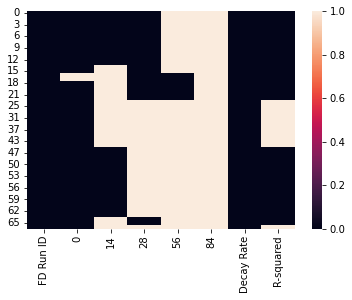

In [55]:
sns.heatmap(decay_final.isnull())

___

### C1. (cont) decay_rate func by Linear Regression

Note: Doesn't need to use the pd.melt(df) for the web app because the raw_df is already in melted form

In [57]:
def decay_rate_lin(df):
    
    # prepare the variables
    df['LogCFU'] = np.log10(df['CFU/g'])
                       
    X = df['Day'].values.reshape(-1,1) #require to reshape, but doesn't have to be float/int
    y = df['LogCFU'].values
    
    # instantiate and fit the model
    model = LinearRegression()
    model.fit(X,y)
    
    decay_rate = model.coef_[0]
    r_squared = model.score(X, y)
    
    return pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})

In [ ]:
# TO-DO: groupby from raw, cal decay, join  

# Unit test: test on InPack_CFU_Test.csv file

In [59]:
decay_t1 = raw.groupby('FD Run ID').apply(decay_rate_lin).reset_index()
decay_t1

,FD Run ID,Decay Rate,R-squared
0,ABKLUB 030823AA,0.0,NaN
1,ABKLUB 031023AA,0.0,NaN
2,ABKLUB 031323AA,0.0,NaN
3,ABKLUB 031623AA #9,0.0,NaN
4,ABKLUB 031823AA #10,0.0,NaN
...,...,...,...
56,IFF10202022-1 T4,0.0,NaN
57,IFF10202022-2 T1,0.0,NaN
58,IFF10202022-2 T2,0.0,NaN
59,IFF10202022-2 T3,0.0,NaN


In [60]:
decay_t1[decay_t1['Decay Rate'] !=0]

,FD Run ID,Decay Rate,R-squared
6,AKLUB 030323 AA,0.013279,1.0
7,AKLUB 030623 AA #5,-0.049469,1.0
8,EDKLUB 022823 03,0.006453,1.0
15,EDKOKO 022823 01,0.093253,1.0


In [61]:
raw[raw['FD Run ID']=='AKLUB 030323 AA']

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Day,Week
18,AKLUB 030323 AA,NaN,NaN,NaN,2023-03-09,2023-03-09,1.790000e+10,3.390000e+11,10.1,NaN,0,0
27,AKLUB 030323 AA,NaN,NaN,NaN,2023-03-09,2023-03-14,2.080000e+10,3.950000e+11,15.7,NaN,5,1


**Insights**: When there is only 2 data points, there is bias which leads to a perfect fit (R2 = 1)

### C2. Use statsmodel 

In [54]:
unpivot_df.head()

,FD Run ID,Day,CFU/g,LogCFU
0,FDL-105EF-T24-CC1,0,1.133667e+11,11.054485
1,FDL-105EF-T24-CC2,0,1.222333e+11,11.087190
2,FDL-105EF-T24-SO1,0,1.133667e+11,11.054485
3,FDL-105EF-T24-SO2,0,1.222333e+11,11.087190
4,FDL-105EF-T24-TMC1,0,1.133667e+11,11.054485


In [55]:
unpivot_df.shape

(118, 4)

In [56]:
c = a.copy()
c

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0.0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14.0,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28.0,8.191111e+10,10.913343


In [57]:
c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 6 to 140
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FD Run ID  3 non-null      object 
 1   Day        3 non-null      float64
 2   CFU/g      3 non-null      float64
 3   LogCFU     3 non-null      float64
dtypes: float64(3), object(1)
memory usage: 120.0+ bytes


*What is sm.add_constant()?*

api , before we fit the model, we need to use the sm. add_constant(X) function, which adds a column of constants to the X dataframe, before passing that into the OLS() function. This is a structural requirement so that the ordinary least squares estimation can be performed properly

In [58]:
c['Day'] = c['Day'].astype('float64')

In [59]:
# Extract the input features and target variable
X = c['Day']
y = c['LogCFU']

In [60]:
X

6       0.0
73     14.0
140    28.0
Name: Day, dtype: float64

In [61]:
# Add a constant term to the input features 
# Add a column of 1s 
X = sm.add_constant(X)

In [62]:
X

,const,Day
6,1.0,0.0
73,1.0,14.0
140,1.0,28.0


In [63]:
# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

In [64]:
results.params

const    11.101897
Day      -0.006684
dtype: float64

In [65]:
# Get slope and r-squared
# .params[0] = const = y-intercept 
# .parmas[1] = slope
coefficient1,coefficient0 = results.params[1], results.params[0]
r_squared = results.rsquared

In [66]:
print(coefficient1, coefficient0)
print(r_squared)

-0.006683664483398799 11.101896502943045
0.9993182217118274


Confirmed the coef and r-squared are the same as Linear Regression model and true results

In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LogCFU   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1466.
Date:                Sat, 10 Jun 2023   Prob (F-statistic):             0.0166
Time:                        15:33:09   Log-Likelihood:                 14.394
No. Observations:                   3   AIC:                            -24.79
Df Residuals:                       1   BIC:                            -26.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1019      0.003   3518.523      0.000      11.062      11.142
Day           -0.0067      0.000    -38.285      0.017      -0.009      -0.004
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                           0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         28.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# 95%CI of the slope
ci95 = results.conf_int(alpha=0.05)
ci95

,0,1
const,11.061805,11.141988
Day,-0.008902,-0.004465


In [69]:
# the CI of the slope
ci95.loc['Day']

0   -0.008902
1   -0.004465
Name: Day, dtype: float64

In [70]:
ci95.loc['Day'][0]

-0.008901861768267507

In [71]:
type(ci95.loc['Day'])

pandas.core.series.Series

In [72]:
ci95.rename(columns={0:'decay_rate_95ci_lower', 1:'decay_rate_95ci_upper'}, inplace=True)

In [73]:
ci95

,decay_rate_95ci_lower,decay_rate_95ci_upper
const,11.061805,11.141988
Day,-0.008902,-0.004465


In [74]:
ci95.drop('const', inplace=True)

In [75]:
ci95

,decay_rate_95ci_lower,decay_rate_95ci_upper
Day,-0.008902,-0.004465


## Decay Rate Calculation Function

In [ ]:
# TO-DO: instanstiate the const col first
# sm.add_const(X)

In [88]:
def decay_rate(df):
    """
    The decay_rate function calculates the rate at which the material's concentration (in Log10_CFU) decay over time.
    The function takes in time (day) as the independent variable (X) and Log10(CFU) as the dependent variable (y).
    A linear regression model is instantiated to calculate the slope, r-squared, and the 95% confidence interval (CI) of the slope.
    The model will skip entries having fewer than 2 datapoints due to avoid overfitting and bias. 
    
    INPUT: a dataframe containing raw plating CFU data (wide format)
        - X (independent variable): time (day) as int or float
        - y (dependent variable): Log10(CFU) as float
        
    OUTPUT: a dataframe containing the samples information, their CFU values at each timepoint, the decay rate over time,
        the R-squared of the linear fit equation, the lower and upper values of the 95% confidence interval of the decay rate.
        - decay_rate: slope of the linear fit equation (m)
        - r-squared: coefficient of determination
        - ci_slope: [lower,upper] values of the slope's 95% CI
    """
    
    df['LogCFU'] = np.log10(df['CFU/g'])
    
    # No calculation if there are only 1 or 2 observant (day-LogCFU)
    if len(df) < 3: 
        decay_df = pd.Series({'Decay Rate': None, 'R-squared': None,
                             'CI95_lower': None,'CI95_upper': None})
        return decay_df
        
    # Extract the input feature and target variable
    X = df[['Day', "const"]] #require to be float/int
    y = df['LogCFU']
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Extract the coefficient and R-squared
    decay_rate = results.params[1]
    r_squared = results.rsquared
    
    # Extract the 95% confidence interval
    ci = results.conf_int(alpha=0.05)
    ci_slope = ci.loc['Day']
    
    decay_df = pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared,
                         'CI95_lower':ci_slope[0], 'CI95_upper':ci_slope[1]})
    
    return decay_df

Unit test 1

In [77]:
t2 = raw.copy()

In [78]:
t2.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Day,Week
0,IFF09152022-2 T1,NaN,NaN,21,2023-01-05,2023-02-27,7.410000e+08,1.410000e+10,8.6,0.254,53,8
1,IFF09152022-2 T2,NaN,NaN,21,2023-01-05,2023-02-27,1.970000e+09,3.750000e+10,10.0,0.198,53,8
3,IFF09152022-2 T3,NaN,NaN,4,2023-01-05,2023-03-01,2.300000e+01,4.500000e+00,8.6,NaN,55,8
4,IFF09152022-2 T4,NaN,NaN,21,2023-01-05,2023-02-27,4.550000e+08,8.640000e+09,7.9,0.267,53,8
5,IFF09152022-3 T1,NaN,NaN,21,2023-01-05,2023-02-27,2.440000e+08,4.640000e+09,4.3,0.227,53,8


In [79]:
t2.shape

(65, 12)

In [80]:
t2 = sm.add_constant(t2)

In [89]:
decay_t2 = t2.groupby('FD Run ID').apply(decay_rate).reset_index()

In [90]:
decay_t2

,FD Run ID,Decay Rate,R-squared,CI95_lower,CI95_upper
0,ABKLUB 030823AA,None,None,None,None
1,ABKLUB 031023AA,None,None,None,None
2,ABKLUB 031323AA,None,None,None,None
3,ABKLUB 031623AA #9,None,None,None,None
4,ABKLUB 031823AA #10,None,None,None,None
...,...,...,...,...,...
56,IFF10202022-1 T4,None,None,None,None
57,IFF10202022-2 T1,None,None,None,None
58,IFF10202022-2 T2,None,None,None,None
59,IFF10202022-2 T3,None,None,None,None


In [91]:
decay_t2[decay_t2['Decay Rate'].notnull()]

,FD Run ID,Decay Rate,R-squared,CI95_lower,CI95_upper


In [696]:
decay_t2_final = pd.merge(left=clean,right=decay_t2,on='FD Run ID')

In [697]:
decay_t2_final

,FD Run ID,T0,Date,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity,Decay Rate,R-squared,CI95_lower,CI95_upper
0,IFF09152022-2 T1,2023-01-05,2023-02-27,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10,NaN,NaN,0.254,None,None,None,None
1,IFF09152022-2 T2,2023-01-05,2023-02-27,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10,NaN,NaN,0.198,None,None,None,None
2,IFF09152022-2 T3,2023-01-05,2023-03-01,NaN,NaN,2.300000e+01,NaN,NaN,4.500000e+00,NaN,NaN,NaN,None,None,None,None
3,IFF09152022-2 T4,2023-01-05,2023-02-27,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09,NaN,NaN,0.267,None,None,None,None
4,IFF09152022-3 T1,2023-01-05,2023-02-27,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09,NaN,NaN,0.227,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,FDL-105K-T42,2023-04-07,2023-04-07,4.030000e+08,NaN,NaN,7.650000e+09,NaN,NaN,NaN,NaN,NaN,None,None,None,None
57,FDL-105K-T44,2023-04-07,2023-04-07,1.130000e+08,NaN,NaN,2.150000e+09,NaN,NaN,NaN,NaN,NaN,None,None,None,None
58,FDL-105EF-T24 TMC1,2023-04-07,2023-04-07,1.570000e+09,NaN,NaN,2.990000e+10,NaN,NaN,0.298,NaN,NaN,None,None,None,None
59,FDL-105EF-T24 TMC2,2023-04-07,2023-04-07,2.120000e+09,NaN,NaN,4.030000e+10,NaN,NaN,0.301,NaN,NaN,None,None,None,None


In [94]:
clean.shape, decay_t2.shape

((61, 12), (61, 5))

In [95]:
decay_t2_final[decay_t2_final.duplicated()]

,FD Run ID,T0,Date,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity,Decay Rate,R-squared,CI95_lower,CI95_upper


**Insights**: this example is a test case for the web app. The raw and clean dfs is from the CFU plating .csv file 

*To-do* in the web app:
1. Add 'const' col before call the decay_rate func
2. Join the 'clean' df with the 'decay_df'
3. Drop duplicates

Unit test 2

In [96]:
unpivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 223
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FD Run ID  118 non-null    object 
 1   Day        118 non-null    object 
 2   CFU/g      118 non-null    float64
 3   LogCFU     118 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.6+ KB


In [97]:
t3 = unpivot_df.copy()

In [106]:
to_unpivot[to_unpivot.duplicated()]

,FD Run ID,0,14,28,56,84
174,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN
175,FDL-111EF-T18-CC1TMC1,1.009111e+11,NaN,NaN,NaN,NaN
176,FDL-111EF-T18-TMC1,8.444444e+10,NaN,NaN,NaN,NaN
177,FDL-111EF-T19,1.089333e+11,NaN,NaN,NaN,NaN
178,FDL-111EF-T19-CC1TMC1,1.427111e+11,NaN,NaN,NaN,NaN
179,FDL-111EF-T19-TMC1,1.072444e+11,NaN,NaN,NaN,NaN
180,FDL-111G-T22,7.304444e+10,NaN,NaN,NaN,NaN
181,FDL-111G-T22-CC1TMC1,7.600000e+10,NaN,NaN,NaN,NaN
182,FDL-111G-T22-TMC1,6.417778e+10,NaN,NaN,NaN,NaN
183,FDL-111G-T23,7.388889e+10,NaN,NaN,NaN,NaN


In [98]:
t3['Day'] = t3['Day'].astype(float)

In [99]:
t3 = sm.add_constant(t3)

In [100]:
decay_t3 = t3.groupby('FD Run ID').apply(decay_rate).reset_index()

In [101]:
decay_t3.head()

,FD Run ID,Decay Rate,R-squared,CI95_lower,CI95_upper
0,FDL-105B-T10-CC1,11.101897,0.999318,-0.008902,-0.004465
1,FDL-105B-T10-CC2,11.171626,0.837602,-0.043805,0.030520
2,FDL-105B-T10-SKP,NaN,NaN,NaN,NaN
3,FDL-105B-T10-Try,NaN,NaN,NaN,NaN
4,FDL-105C-T14-Try,11.040415,0.848867,-0.037421,0.025656


In [401]:
decay_t3_final = pd.merge(left=to_unpivot,right=decay_t3,on='FD Run ID')

In [402]:
decay_t3_final.head()

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
0,FDL-105EF-T24-CC1,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789
1,FDL-105EF-T24-CC2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282
2,FDL-105EF-T24-SO1,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955
3,FDL-105EF-T24-SO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218
4,FDL-105EF-T24-TMC1,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266


In [403]:
decay_t3_final[decay_t3_final.duplicated()]

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
24,FDL-111EF-T18,8.740000e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,FDL-111EF-T18-CC1TMC1,1.009111e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,FDL-111EF-T18-TMC1,8.444444e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,FDL-111EF-T19,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,FDL-111EF-T19-CC1TMC1,1.427111e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,FDL-111EF-T19-TMC1,1.072444e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,FDL-111G-T22,7.304444e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,FDL-111G-T22-CC1TMC1,7.600000e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,FDL-111G-T22-TMC1,6.417778e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,FDL-111G-T23,7.388889e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [405]:
decay_t3_final.drop_duplicates(inplace=True)

---

## D. 95% CI Graph

In [114]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0.0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14.0,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28.0,8.191111e+10,10.913343


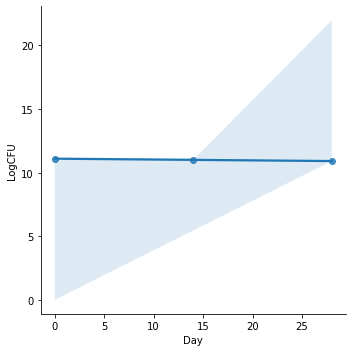

In [115]:
# provide 95%CI grpah
sns.lmplot(x='Day', y='LogCFU', data=a, fit_reg=True, ci=95)
#sns.lmplot(x='Day', y='LogCFU', data=a, fit_reg=True, ci=95, n_boot=1000)

---

# Joining with In-pack Analysis

## A. Structure of final In-pack report TO ACHIEVE

In [118]:
inpack_df = pd.read_excel("/Users/miu/IFF_st/Data files/PIVOT Sample Master List 2023_10May23.xlsm", sheet_name='WP4 In-pack Data')
inpack_df.head()

,Unique ID,FD sample ID,FD Run ID,Strain,Cryo mix,Sub-Sample,Ferm Condition,Storage form,Temperature (°C),Container,...,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10,Week 0 Aw,Week 2 Aw,Week 4 Aw,Week 8 Aw,Week 12 Aw
0,1.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_n,"Greens, high EPS",Pellet,21,Mylar,...,0.996659,0.000881,-0.008642,-0.006880,168.374192,0.165,NaN,0.175,0.205,NaN
1,2.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_cacl2,"Greens, high EPS",Pellet,21,Mylar,...,0.939662,0.005588,-0.016840,-0.005663,116.142074,0.165,NaN,0.125,0.153,NaN
2,3.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,unbulked powder_21_mylar_n,"Greens, high EPS",Unbulked powder,21,Mylar,...,0.990339,0.002946,-0.018166,-0.012273,85.502213,0.289,NaN,0.23,0.268,NaN
3,4.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, pre-dried bulking_21_mylar_n","Greens, high EPS","Bulked powder, pre-dried bulking",21,Mylar,...,0.993116,0.001788,-0.012742,-0.009167,88.342199,0.224,NaN,0.174,0.221,NaN
4,5.0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, w/o sio2_21_mylar_n","Greens, high EPS","Bulked powder, w/o SiO2",21,Mylar,...,0.998539,0.001091,-0.015640,-0.013459,73.940614,0.229,NaN,0.21,0.257,NaN


In [119]:
inpack_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Unique ID', 'FD sample ID', 'FD Run ID', 'Strain', 'Cryo mix',
       'Sub-Sample', 'Ferm Condition', 'Storage form', 'Temperature (°C)',
       'Container', 'Bulking', 'Desiccant', 'Quantity (g)', 'Sample location',
       'Week 0 CFU/g', 'Week 2 CFU/g', 'Week 4 CFU/g', 'Week 8 CFU/g',
       'Week 12 CFU/g', 'decay_rate_fitted', 'Rsquared_fitted',
       'decay_rate_errbar', 'decay_rate_lower95interval',
       'decay_rate_upper95interval', 'estimate_day_2e10', 'Week 0 Aw',
       'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],
      dtype='object')>

In [120]:
inpack_df.drop(['Unique ID','Quantity (g)','Sample location','Week 0 Aw',
                'Week 2 Aw', 'Week 4 Aw', 'Week 8 Aw', 'Week 12 Aw'],axis=1,inplace=True)

*In-pack* available features:
- Key: FD Run ID
- CFU values by week
- Water activity by week

**Features carry** to *In-pack*:
- Key: **'FD Run ID'** 
- Cols: 'Strain','FD Recipe', 'Cryo mix','Ferm condition','Container', 

**User Inputs** for 'In-pack' (create a new form/table, different from the Sample Info table):
- 'Temperature (°C)', 'Container', 'Bulking', 'Desiccant', 'Storage form'
    
    Note:
    - Ferm condition: shorten the description from the "Info"
    
**Features to calculate**
- sub-sample: generated from storage form, temp, container, desciccant
- 'decay_rate_fitted', 'Rsquared_fitted','decay_rate_errbar', 'decay_rate_lower95interval', 'decay_rate_upper95interval', 'estimate_day_2e10'

In [121]:
inpack_df.head()

,FD sample ID,FD Run ID,Strain,Cryo mix,Sub-Sample,Ferm Condition,Storage form,Temperature (°C),Container,Bulking,...,Week 2 CFU/g,Week 4 CFU/g,Week 8 CFU/g,Week 12 CFU/g,decay_rate_fitted,Rsquared_fitted,decay_rate_errbar,decay_rate_lower95interval,decay_rate_upper95interval,estimate_day_2e10
0,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_n,"Greens, high EPS",Pellet,21,Mylar,PVT,...,NaN,2.584000e+11,1.490000e+11,NaN,-0.007761,0.996659,0.000881,-0.008642,-0.006880,168.374192
1,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,pellet_21_mylar_cacl2,"Greens, high EPS",Pellet,21,Mylar,PVT,...,NaN,2.698000e+11,9.500000e+10,NaN,-0.011252,0.939662,0.005588,-0.016840,-0.005663,116.142074
2,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,unbulked powder_21_mylar_n,"Greens, high EPS",Unbulked powder,21,Mylar,PVT,...,NaN,1.774600e+11,5.624000e+10,NaN,-0.015220,0.990339,0.002946,-0.018166,-0.012273,85.502213
3,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, pre-dried bulking_21_mylar_n","Greens, high EPS","Bulked powder, pre-dried bulking",21,Mylar,PVT,...,NaN,1.014600e+11,4.522000e+10,NaN,-0.010955,0.993116,0.001788,-0.012742,-0.009167,88.342199
4,IFF09152022-1,FDL-099A,Klebsiella variicola,PVT,"bulked powder, w/o sio2_21_mylar_n","Greens, high EPS","Bulked powder, w/o SiO2",21,Mylar,PVT,...,NaN,9.918000e+10,3.648000e+10,NaN,-0.014549,0.998539,0.001091,-0.015640,-0.013459,73.940614


## B. Dataset Preparation

### Sample Info

In [122]:
master_lst = pd.read_csv('sample_info.csv')

In [123]:
master_lst.head()

,FD sample ID,FD Run ID,Strain,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),Broth titer (CFU/mL),Broth age (day),...,FD run time (hr),Primary ramp rate (C/min),PA receive date,Dried appearance,Container,Water activity,Viability (CFU/g),Cryo mix Coef,Yield (%),Log Loss
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,fused/melted moist cake,Foil pouch,0.37,NaN,0.380,NaN,NaN
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.06,1.840000e+11,0.342,17.78,-0.75
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, high viscosity by...",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, some dust",Foil pouch,0.24,6.610000e+10,0.285,15.96,-0.80
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.05,3.150000e+11,0.285,25.36,-0.60
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, low viscosity",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-22 00:00:00,"friable cake, readily broke into pellets",Foil pouch,0.42,4.070000e+10,0.380,13.11,-0.88


In [124]:
master_lst.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['FD sample ID', 'FD Run ID', 'Strain', 'EFT date', 'Broth ID',
       'Fermentation Scale', 'Ferm condition', 'EFT (hr)',
       'Broth titer (CFU/mL)', 'Broth age (day)', 'Pelletization date',
       'Cryo mix', 'Ingredient 1', 'Ingredient 2', 'Ingredient 3',
       'Cryo mix addition rate', 'FD start date', 'FD cycle recipe',
       'FD pressure (mTorr)', 'FD run time (hr)', 'Primary ramp rate (C/min)',
       'PA receive date', 'Dried appearance', 'Container', 'Water activity',
       'Viability (CFU/g)', 'Cryo mix Coef', 'Yield (%)', 'Log Loss'],
      dtype='object')>

**INFO from Master list TO MERGE**

*To-do* in the web app:
1. Map the 'Ferm condition'

In [529]:
info_df = master_lst[['FD sample ID', 'FD Run ID', 'Strain','Ferm condition','Cryo mix']]

In [530]:
info_df.head(10)

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,"Potato peptone and tryptone, high viscosity by...",SKP
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,"Potato peptone and tryptone, high viscosity by...",DSR
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,"Potato peptone and tryptone, high viscosity by...",PVT70%
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,"Potato peptone and tryptone, high viscosity by...",PVT70%
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,"Potato peptone and tryptone, low viscosity",SKP
5,22PT1202-3,FDL-105B-T06,Kosakonia sacchari,"Potato peptone and tryptone, low viscosity",DSR
6,22PT1202-4,FDL-105B-T07,Kosakonia sacchari,"Potato peptone and tryptone, high viscosity by...",SKP
7,22PT1117-7,FDL-105B-T08,Klebsiella variicola,"Potato peptone and tryptone, low viscosity",SKP
8,22PT1202-6,FDL-105B-T09,Kosakonia sacchari,"Potato peptone and tryptone, high viscosity by...",DSR
9,22PT1117-8,FDL-105B-T10,Klebsiella variicola,"Potato peptone and tryptone, low viscosity",PVT70%


In [660]:
info_df['Ferm condition'].nunique()

8

In [531]:
info_df['Ferm condition'] = info_df['Ferm condition'].apply(lambda x:x.strip())

In [532]:
# TODO: change 'FD cycle recipe' -> 'FD recipe'
info_df.rename(columns={'FD cycle recipe':'FD recipe'}, inplace=True)

In [ ]:
# TODO: mapping dictionary for 'Ferm condition'
# e.g.: {Peptone only}:['P only']

In [534]:
info_df['Ferm condition'].value_counts()

Tryptone+Peptone                                                                11
Glucose, no EPS, CR                                                             10
Glucose                                                                         10
Peptone only, upconcentrated                                                     7
Tryptone only                                                                    7
Peptone only                                                                     6
Potato peptone and tryptone, low viscosity                                       6
Potato peptone and tryptone, high viscosity by post-ferm addition of 0.7% XG     6
tryptone only                                                                    6
Glucose, high EPS, CR                                                            6
repeat of P080-22-Y007, tryptone + potato peptone                                3
Tryptone + potato peptone, lower top feed rate, no EPS                           3
tryp

In [535]:
inpack_df['Ferm Condition'].value_counts()

T only               41
P only               29
T+P, no EPS          25
T+P, 0.7% XG         22
Glucose, no EPS      19
T+P, high EPS        19
Greens, high EPS     15
Glucose, high EPS     9
P only, con           6
T+P                   1
Name: Ferm Condition, dtype: int64

In [536]:
mapping_ferm_cond = {
    'Tryptone+Peptone': 'T+P',
    'Tryptone only': 'T only',
    'Glucose': 'Glucose, no EPS',
    'Glucose, no EPS, CR': 'Glucose, no EPS',
    'Peptone only, upconcentrated': 'P only, con',
    'Potato peptone and tryptone, high viscosity by post-ferm addition of 0.7% XG': 'T+P, 0.7% XG',
    'Peptone only': 'P only',
    'Potato peptone and tryptone, low viscosity': 'T+P',
    'Glucose, high EPS, CR': 'Glucose, high EPS',
    'tryptone only': 'T only',
    'repeat of P080-22-Y007, tryptone + potato peptone': 'T+P',
    'Tryptone + potato peptone, lower top feed rate, no EPS': 'T+P',
    'tryptone + potato peptone, low top feed rate, no EPS, w 0.7% XG': 'T+P, 0.7% XG',
    'repeat of P080-22-Y005, tryptone + potato peptone': 'T+P',
    'Potato peptone only, less EPS, pH control': 'P only',
    'Glucose, no EPS': 'Glucose, no EPS',
    'Glucose, high EPS, CR broth': 'Glucose, high EPS',
    'Greens': 'Greens, high EPS',
    'Glucose, high EPS': 'Glucose, no EPS'
}

In [537]:
# Iterate through the column and replace values
for i in range(len(info_df['Ferm condition'])):
    if info_df['Ferm condition'][i] in mapping_ferm_cond:
        info_df['Ferm condition'][i] = mapping_ferm_cond[info_df['Ferm condition'][i]]

In [538]:
info_df.head()

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,"T+P, 0.7% XG",SKP
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,"T+P, 0.7% XG",DSR
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,"T+P, 0.7% XG",PVT70%
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,"T+P, 0.7% XG",PVT70%
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,T+P,SKP


In [539]:
info_df['Ferm condition'].value_counts()

T+P                  26
Glucose, no EPS      23
T only               13
T+P, 0.7% XG          9
Glucose, high EPS     9
P only                9
P only, con           7
Greens, high EPS      1
Name: Ferm condition, dtype: int64

In [540]:
info_df.shape

(97, 5)

In [581]:
info_df['FD sample ID'].value_counts()

23PT0406-KLUB    11
23PT0227-8        7
23PT0227-6        6
23PT0227-4        6
22PT1202-10       1
                 ..
23PT0119-5        1
23PT0119-3        1
23PT0119-2        1
22PT1117-4        1
23PT0405-KOKO     1
Name: FD sample ID, Length: 71, dtype: int64

In [589]:
info_df[info_df['FD sample ID']=='23PT0227-6']

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix
64,23PT0227-6,FDL-111A-T03,Kosakonia sacchari,P only,PVT70%
68,23PT0227-6,FDL-111C-T11,Kosakonia sacchari,P only,PVT70%
72,23PT0227-6,FDL-111D-T15,Kosakonia sacchari,P only,PVT70%
75,23PT0227-6,FDL-111EF-T19,Kosakonia sacchari,P only,PVT70%
79,23PT0227-6,FDL-111G-T23,Kosakonia sacchari,P only,PVT70%
83,23PT0227-6,FDL-111H-T27,Kosakonia sacchari,P only,PVT70%


**Insights**: each parent has unique Strain, Ferm condition, and Cryo mix

- The children are different from each other by FD Run ID and FD recipe but it doesn't important


**In-pack CFU TO MERGE**

The actual cfu df from the web app will be decay_t2_final, processed from Inpack_CFU_Test.csv file

*To-do* in the web app:
1. Drop 'T0' and 'Date' before merging
2. Incorportate thefuzz to calculate the ratio naming in case human errors from data entry

In [129]:
# Use decay_t3_final for now as the test
decay_t3_final.head()

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
0,FDL-105EF-T24-CC1,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789
1,FDL-105EF-T24-CC2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282
2,FDL-105EF-T24-SO1,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955
3,FDL-105EF-T24-SO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218
4,FDL-105EF-T24-TMC1,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266


In [130]:
cfu_df = decay_t3_final.copy()

In [165]:
cfu_df.shape

(56, 10)

**In-pack USER INPUT TO MERGE**

*To-do* in the web app:
1. Col name: 'Temperature (C)' - no degree sign

*To-do* for the historical data:
1. Col name: 'Temperature (C)' - no degree sign
2. Strip all spaces in 'Desiccant' col

In [431]:
cols = ['FD sample ID', 'FD Run ID','Storage form','Container','Temperature (°C)','Bulking','Desiccant']
real_input_df = inpack_df[cols]

In [432]:
real_input_df.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant
0,IFF09152022-1,FDL-099A,Pellet,Mylar,21,PVT,N
1,IFF09152022-1,FDL-099A,Pellet,Mylar,21,PVT,2%CaCl2
2,IFF09152022-1,FDL-099A,Unbulked powder,Mylar,21,PVT,5%SIO2
3,IFF09152022-1,FDL-099A,"Bulked powder, pre-dried bulking",Mylar,21,PVT,5%SIO2
4,IFF09152022-1,FDL-099A,"Bulked powder, w/o SiO2",Mylar,21,PVT,5%SIO2


In [433]:
# Use the sub group of id_to_test (the samples with unique ids to pivot -> calculate decay)
real_input_df = real_input_df[real_input_df['FD Run ID'].isin(id_to_test)]

In [434]:
real_input_df['Desiccant'].unique()

array(['2%CaCl2', '10%CaCl2', '10%SIO2', '25%SIO2', '5%TMC', '25%TMC',
       '10%TMC', '5%SIO2', '5%TMC+2%CaCl2', '2% CaCl2', '5%TMC+2% CaCl2'],
      dtype=object)

In [435]:
# remove all spaces for 'Desiccant' col
real_input_df['Desiccant'] = real_input_df['Desiccant'].apply(lambda x:x.strip().replace(" ", ""))

In [436]:
real_input_df['FD Run ID'].value_counts()

FDL-111EF-T19-TMC1       2
FDL-111G-T23             2
FDL-111G-T22-CC1TMC1     2
FDL-111G-T22             2
FDL-111G-T23-CC1TMC1     2
FDL-111EF-T19-CC1TMC1    2
FDL-111EF-T19            2
FDL-111EF-T18-TMC1       2
FDL-111EF-T18-CC1TMC1    2
FDL-111EF-T18            2
FDL-111G-T22-TMC1        2
FDL-111B-T8-TMC1         1
FDL-111G-T23-TMC1        1
FDL-105K-T44             1
FDL-105K-T42             1
FDL-111D-T15             1
FDL-111D-T15-TMC1        1
FDL-111D-T15-CC1         1
FDL-111D-T14             1
FDL-111D-T14-TMC1        1
FDL-111D-T14-CC1         1
FDL-111A-T2              1
FDL-111B-T8-CC1          1
FDL-111A-T2-TMC1         1
FDL-111A-T2-TMC2         1
FDL-111A-T3              1
FDL-111A-T3-TMC1         1
FDL-111B-T8              1
FDL-111A-T4              1
FDL-111A-T4-TMC1         1
FDL-111A-T4-TMC2         1
FDL-111A-T3-TMC2         1
FDL-105EF-T24-CC1        1
FDL-105EF-T24-CC2        1
FDL-105EF-T26-TMC2       1
FDL-105EF-T24-SO1        1
FDL-105EF-T24-SO2        1
F

In [437]:
real_input_df.shape

(67, 7)

In [438]:
real_input_df[real_input_df.duplicated()]

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant
174,23PT0227-4,FDL-111EF-T18,Bulked powder,Mylar,21,PVT,5%SIO2
175,23PT0227-4,FDL-111EF-T18-CC1TMC1,Bulked powder,Mylar,21,PVT,5%TMC+2%CaCl2
176,23PT0227-4,FDL-111EF-T18-TMC1,Bulked powder,Mylar,21,PVT,5%TMC
177,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2
178,23PT0227-6,FDL-111EF-T19-CC1TMC1,Bulked powder,Mylar,21,PVT,5%TMC+2%CaCl2
179,23PT0227-6,FDL-111EF-T19-TMC1,Bulked powder,Mylar,21,PVT,5%TMC
180,23PT0227-4,FDL-111G-T22,Bulked powder,Mylar,21,PVT,5%SIO2
181,23PT0227-4,FDL-111G-T22-CC1TMC1,Bulked powder,Mylar,21,PVT,5%TMC+2%CaCl2
182,23PT0227-4,FDL-111G-T22-TMC1,Bulked powder,Mylar,21,PVT,5%TMC
183,23PT0227-6,FDL-111G-T23,Bulked powder,Mylar,21,PVT,5%SIO2


In [439]:
real_input_df.drop_duplicates(inplace=True)

In [441]:
real_input_df.shape

(56, 7)

## C. Join the Dataframes

1. real_input_df + decay_df ON 'FD Run ID' = A
2. A + info_df ON 'FD sample ID' = B

**NOTE**

MUST have the USER INPUT of *"FD sample ID"* to merge the dfs, because 
- cfu_df (decay_df) doesn't have FD sample ID
- info_df doesn't contain all the FD Run ID

Thus, can't merge on FD Run ID from these 2 dfs. 

In [541]:
info_df.shape, real_input_df.shape, cfu_df.shape

((97, 5), (56, 7), (56, 10))

In [542]:
same_ids = real_input_df[real_input_df['FD Run ID'].isin(cfu_df['FD Run ID'])]

In [543]:
same_ids.shape

(56, 7)

temp1 = real_input_df + decay_df ON 'FD Run ID'

In [544]:
temp1 = pd.merge(left=real_input_df, right=cfu_df, on='FD Run ID', how='left')

In [545]:
temp1.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266


In [546]:
temp1.shape

(56, 16)

---

temp1 + info_df ON 'FD sample ID' = temp2

In [556]:
temp2 = pd.merge(left=temp1, right=info_df, on=['FD sample ID', 'FD Run ID'], how='left')

In [557]:
temp2.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789,NaN,NaN,NaN
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282,NaN,NaN,NaN
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955,NaN,NaN,NaN
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218,NaN,NaN,NaN
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266,NaN,NaN,NaN


In [558]:
temp2.shape

(56, 19)

<AxesSubplot:>

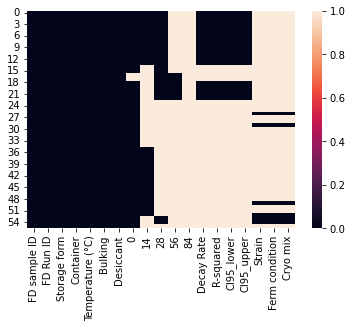

In [559]:
sns.heatmap(temp2.isnull())

**Note**: Ferm condition, Cryo mix, and Strain don't show after merging because the exact ['FD sample ID', 'FD Run ID'] don't always exist in info_df

In [458]:
temp2.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['FD sample ID', 'FD Run ID', 'Storage form', 'Container',
       'Temperature (°C)', 'Bulking', 'Desiccant', '0', '14', '28', '56', '84',
       'Decay Rate', 'R-squared', 'CI95_lower', 'CI95_upper', 'FD recipe',
       'Strain', 'Ferm condition', 'Cryo mix'],
      dtype='object')>

In [552]:
temp2 = temp2[['FD sample ID', 'FD Run ID', 'Strain', 'Ferm condition', 'Cryo mix',
               'Storage form', 'Container', 'Temperature (°C)', 'Bulking', 'Desiccant', 
               '0', '14', '28', '56', '84', 'Decay Rate', 'R-squared', 'CI95_lower', 'CI95_upper']]

In [560]:
temp2.sort_values(by='FD sample ID')

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
21,22PT1102-7,FDL-105D-T20-Try,Bulked powder,Mylar,21,Tryptone,5%SIO2,1.178000e+11,NaN,8.064444e+10,6.291111e+10,NaN,11.061691,0.985754,-0.012295,0.002566,NaN,NaN,NaN
20,22PT1102-8,FDL-105C-T14-Try,Bulked powder,Mylar,21,Tryptone,5%SIO2,1.000667e+11,NaN,9.035556e+10,4.686667e+10,NaN,11.040415,0.848867,-0.037421,0.025656,NaN,NaN,NaN
19,22PT1117-5,FDL-105C-T15-Try,Bulked powder,Mylar,21,Tryptone,5%SIO2,6.502222e+10,NaN,2.744444e+10,7.177778e+09,NaN,10.847705,0.984521,-0.044320,0.010138,NaN,NaN,NaN
18,22PT1117-5,FDL-105C-T15-SKP,Bulked powder,Mylar,21,SKP,5%SIO2,6.502222e+10,NaN,2.660000e+10,8.022222e+09,NaN,10.835130,0.992974,-0.033573,0.001117,NaN,NaN,NaN
17,22PT1117-8,FDL-105B-T10-Try,Bulked powder,Mylar,21,Tryptone,5%SIO2,NaN,NaN,3.293333e+10,2.153333e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,22PT1117-8,FDL-105B-T10-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.260333e+11,1.026000e+11,8.191111e+10,NaN,NaN,11.101897,0.999318,-0.008902,-0.004465,NaN,NaN,NaN
7,22PT1117-8,FDL-105B-T10-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.406000e+11,1.336333e+11,9.162222e+10,NaN,NaN,11.171626,0.837602,-0.043805,0.030520,NaN,NaN,NaN
16,22PT1117-8,FDL-105B-T10-SKP,Bulked powder,Mylar,21,SKP,5%SIO2,NaN,NaN,6.797778e+10,4.137778e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,23PT0119-2,FDL-105EF-T22-Try,Bulked powder,Mylar,21,Tryptone,5%SIO2,9.204444e+10,NaN,5.742222e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,23PT0119-4,FDL-105G-T33-Try,Bulked powder,Mylar,21,Tryptone,5%SIO2,5.151111e+10,NaN,3.420000e+10,1.604444e+10,NaN,10.737039,0.971299,-0.028804,0.010712,NaN,NaN,NaN


In [561]:
temp2.sort_values(by='FD sample ID')['FD sample ID'].value_counts()

23PT0227-6    13
23PT0227-4    12
23PT0119-5     7
23PT0119-8     6
23PT0227-8     6
22PT1117-8     4
22PT1117-5     2
22PT1102-7     1
22PT1102-8     1
23PT0119-2     1
23PT0119-4     1
23PT0126-2     1
23PT0126-5     1
Name: FD sample ID, dtype: int64

**Q: Why don't values from `info_df` show in the merged df??**

A: The  (e.g. No 23PT0119-5 and 105EF-T24, only the derivative of 105EF-T24)

Unit test 1

In [562]:
info_df[info_df['FD sample ID']=='23PT0119-5']

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix
23,23PT0119-5,105EF-T24,Kosakonia sacchari,T only,PVT70%


In [563]:
temp2[temp2['FD sample ID']=='23PT0119-5']

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789,NaN,NaN,NaN
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282,NaN,NaN,NaN
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955,NaN,NaN,NaN
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218,NaN,NaN,NaN
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266,NaN,NaN,NaN
5,23PT0119-5,FDL-105EF-T24-TMC2,Bulked powder,Mylar,21,PVT,25%TMC,1.222333e+11,1.000667e+11,4.028000e+10,NaN,NaN,11.138573,0.880036,-0.097992,0.063556,NaN,NaN,NaN
15,23PT0119-5,FDL-105EF-T24-SKP,Bulked powder,Mylar,21,SKP,5%SIO2,1.068222e+11,NaN,3.800000e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [566]:
merge_1 = temp2[temp2['FD sample ID']=='23PT0119-5']

In [567]:
merge_1.drop(['Strain','Ferm condition','Cryo mix'],axis=1,inplace=True)

In [568]:
merge_1 = merge_1.merge(info_df.drop('FD Run ID',axis=1), on='FD sample ID')

In [569]:
merge_1
# rearrange the cols order later

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789,Kosakonia sacchari,T only,PVT70%
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282,Kosakonia sacchari,T only,PVT70%
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955,Kosakonia sacchari,T only,PVT70%
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218,Kosakonia sacchari,T only,PVT70%
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266,Kosakonia sacchari,T only,PVT70%
5,23PT0119-5,FDL-105EF-T24-TMC2,Bulked powder,Mylar,21,PVT,25%TMC,1.222333e+11,1.000667e+11,4.028000e+10,NaN,NaN,11.138573,0.880036,-0.097992,0.063556,Kosakonia sacchari,T only,PVT70%
6,23PT0119-5,FDL-105EF-T24-SKP,Bulked powder,Mylar,21,SKP,5%SIO2,1.068222e+11,NaN,3.800000e+10,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,T only,PVT70%


Unit test 2: **the issue** lies here
1. The *info_df* only contains the *children in FD Run ID*
2. The *merge_2* contains the *children and grandchildren in FD Run ID*
3. A *parent* has many *children* differs in *FD recipe*
    - how to extract the *children* from the *grandchildren* to pass down the parent's info?

In [574]:
info_df[info_df['FD sample ID']=='23PT0227-6']

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix
64,23PT0227-6,FDL-111A-T03,Kosakonia sacchari,P only,PVT70%
68,23PT0227-6,FDL-111C-T11,Kosakonia sacchari,P only,PVT70%
72,23PT0227-6,FDL-111D-T15,Kosakonia sacchari,P only,PVT70%
75,23PT0227-6,FDL-111EF-T19,Kosakonia sacchari,P only,PVT70%
79,23PT0227-6,FDL-111G-T23,Kosakonia sacchari,P only,PVT70%
83,23PT0227-6,FDL-111H-T27,Kosakonia sacchari,P only,PVT70%


In [575]:
merge_2 = temp2[temp2['FD sample ID']=='23PT0227-6']
merge_2

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
26,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
27,23PT0227-6,FDL-111EF-T19-CC1TMC1,Bulked powder,Mylar,21,PVT,5%TMC+2%CaCl2,1.427111e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,23PT0227-6,FDL-111EF-T19-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.072444e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,23PT0227-6,FDL-111G-T23,Bulked powder,Mylar,21,PVT,5%SIO2,7.388889e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,23PT0227-6,FDL-111G-T23-CC1TMC1,Bulked powder,Mylar,21,PVT,5%TMC+2%CaCl2,7.811111e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,23PT0227-6,FDL-111G-T23-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,7.895556e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,23PT0227-6,FDL-111A-T3,Bulked powder,Mylar,21,PVT,5%SIO2,1.953200e+10,2.698000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,23PT0227-6,FDL-111A-T3-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.960800e+10,3.458000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,23PT0227-6,FDL-111A-T3-TMC2,Bulked powder,Mylar,21,PVT,25%TMC,1.960800e+10,4.218000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,23PT0227-6,FDL-111D-T15-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.498889e+11,3.597333e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [576]:
merge_2.shape

(13, 19)

In [577]:
merge_2.drop(['Strain','Ferm condition','Cryo mix'],axis=1,inplace=True)

In [578]:
merge_2 = merge_2.merge(info_df.drop('FD Run ID',axis=1), on='FD sample ID')

In [579]:
merge_2
# rearrange the cols order later

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
1,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
2,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
3,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
4,23PT0227-6,FDL-111EF-T19,Bulked powder,Mylar,21,PVT,5%SIO2,1.089333e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,23PT0227-6,FDL-111G T23 TMC1,Bulked powder,Mylar,21,PVT,5%TMC,7.895556e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
74,23PT0227-6,FDL-111G T23 TMC1,Bulked powder,Mylar,21,PVT,5%TMC,7.895556e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
75,23PT0227-6,FDL-111G T23 TMC1,Bulked powder,Mylar,21,PVT,5%TMC,7.895556e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%
76,23PT0227-6,FDL-111G T23 TMC1,Bulked powder,Mylar,21,PVT,5%TMC,7.895556e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kosakonia sacchari,P only,PVT70%


In [591]:
merge_2[merge_2.duplicated()].shape

(65, 19)

In [593]:
# unique merge_2 -> confirm the shape of original merge_2 before merging with info_df
78 - 65

13

**SOLUTION**

Each parent has unique Strain, Ferm condition, and Cryo mix regardless different FD Run ID and FD Recipe

-> Drop 'FD Run ID' and 'FD Recipe'

-> Keep the unique 'FD sample ID' 

In [602]:
info_df.head()

,FD sample ID,FD Run ID,Strain,Ferm condition,Cryo mix
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,"T+P, 0.7% XG",SKP
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,"T+P, 0.7% XG",DSR
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,"T+P, 0.7% XG",PVT70%
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,"T+P, 0.7% XG",PVT70%
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,T+P,SKP


In [603]:
info_df.shape

(97, 5)

In [604]:
info_df.nunique()

FD sample ID      71
FD Run ID         97
Strain             2
Ferm condition     8
Cryo mix           3
dtype: int64

In [627]:
info_to_test = info_df.copy()

In [628]:
info_to_test.drop(['FD Run ID'],axis=1,inplace=True)

In [624]:
info_to_test[info_to_test.duplicated()].count()

FD sample ID      26
Strain            26
Ferm condition    26
Cryo mix          26
dtype: int64

In [625]:
97-26

71

In [629]:
info_to_test = info_to_test.drop_duplicates()

Test the merge 

In [666]:
temp2.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789,NaN,NaN,NaN
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282,NaN,NaN,NaN
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955,NaN,NaN,NaN
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218,NaN,NaN,NaN
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266,NaN,NaN,NaN


In [640]:
temp2_test = temp2.copy()

In [641]:
info_to_test.shape, temp2_test.shape

((71, 4), (56, 19))

In [642]:
temp2_test.drop(['Strain','Ferm condition','Cryo mix'], axis=1, inplace=True)

In [643]:
merge_test = pd.merge(temp2_test, info_to_test, on='FD sample ID')

In [647]:
merge_test.shape

(56, 19)

In [648]:
merge_test.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789,Kosakonia sacchari,T only,PVT70%
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282,Kosakonia sacchari,T only,PVT70%
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955,Kosakonia sacchari,T only,PVT70%
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218,Kosakonia sacchari,T only,PVT70%
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266,Kosakonia sacchari,T only,PVT70%


In [649]:
# Re-arrange the columns
merge_test = merge_test[['FD sample ID','FD Run ID','Strain','Cryo mix','Ferm condition',
                         'Storage form', 'Container', 'Temperature (°C)', 'Bulking', 'Desiccant',
                         '0','14','28','56','84','Decay Rate','R-squared','CI95_lower','CI95_upper']]

In [651]:
merge_test.head()

,FD sample ID,FD Run ID,Strain,Cryo mix,Ferm condition,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
0,23PT0119-5,FDL-105EF-T24-CC1,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789
1,23PT0119-5,FDL-105EF-T24-CC2,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282
2,23PT0119-5,FDL-105EF-T24-SO1,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955
3,23PT0119-5,FDL-105EF-T24-SO2,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218
4,23PT0119-5,FDL-105EF-T24-TMC1,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266


## Joining all the dataframes function

**Info**

TO-DO in the web app
1. Select info = [['FD sample ID','Strain','Ferm condition','Cryo mix']]
2. Map the 'Ferm condition'
3. Drop duplicates to keep the unique 'FD sample ID'

In [668]:
full_info = pd.read_csv('sample_info.csv')
full_info.head()

,FD sample ID,FD Run ID,Strain,EFT date,Broth ID,Fermentation Scale,Ferm condition,EFT (hr),Broth titer (CFU/mL),Broth age (day),...,FD run time (hr),Primary ramp rate (C/min),PA receive date,Dried appearance,Container,Water activity,Viability (CFU/g),Cryo mix Coef,Yield (%),Log Loss
0,22PT1202-10,FDL-105A-T01,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,fused/melted moist cake,Foil pouch,0.37,NaN,0.380,NaN,NaN
1,22PT1202-12,FDL-105A-T02,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.06,1.840000e+11,0.342,17.78,-0.75
2,22PT1202-5,FDL-105A-T03,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, high viscosity by...",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, some dust",Foil pouch,0.24,6.610000e+10,0.285,15.96,-0.80
3,22PT1202-11,FDL-105A-T04,Klebsiella variicola,2022-12-01,P080-22-Y048,14L,"Potato peptone and tryptone, high viscosity by...",48.0,3.540000e+11,1.0,...,57.0,NaN,2022-12-20 00:00:00,"Collapse, no dust",Foil pouch,0.05,3.150000e+11,0.285,25.36,-0.60
4,22PT1202-1,FDL-105B-T05,Kosakonia sacchari,2022-12-01,P080-22-Y046,14L,"Potato peptone and tryptone, low viscosity",48.0,1.180000e+11,1.0,...,57.0,NaN,2022-12-22 00:00:00,"friable cake, readily broke into pellets",Foil pouch,0.42,4.070000e+10,0.380,13.11,-0.88


In [669]:
info_merge = full_info[['FD sample ID', 'Strain', 'Ferm condition', 'Cryo mix']]

In [671]:
for i in range(len(info_df['Ferm condition'])):
    if info_merge['Ferm condition'][i] in mapping_ferm_cond:
        info_merge['Ferm condition'][i] = mapping_ferm_cond[info_merge['Ferm condition'][i]]

# drop duplicates
info_merge = info_merge.drop_duplicates()

In [673]:
info_merge.shape

(71, 4)

In [677]:
info_merge.head()

,FD sample ID,Strain,Ferm condition,Cryo mix
0,22PT1202-10,Klebsiella variicola,"T+P, 0.7% XG",SKP
1,22PT1202-12,Klebsiella variicola,"T+P, 0.7% XG",DSR
2,22PT1202-5,Kosakonia sacchari,"T+P, 0.7% XG",PVT70%
3,22PT1202-11,Klebsiella variicola,"T+P, 0.7% XG",PVT70%
4,22PT1202-1,Kosakonia sacchari,"Potato peptone and tryptone, low viscosity",SKP


**User input**

In [655]:
real_input_df.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant
119,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2
120,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2
121,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2
122,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2
123,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC


**CFU**

In [667]:
decay_t3_final.head()

,FD Run ID,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
0,FDL-105EF-T24-CC1,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789
1,FDL-105EF-T24-CC2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282
2,FDL-105EF-T24-SO1,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955
3,FDL-105EF-T24-SO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218
4,FDL-105EF-T24-TMC1,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266


In [658]:
decay_t2_final.head()

,FD Run ID,T0,Date,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,W0_CFU/g,W1_CFU/g,W8_CFU/g,W0_Water Activity,W1_Water Activity,W8_Water Activity,Decay Rate,R-squared,CI95_lower,CI95_upper
0,IFF09152022-2 T1,2023-01-05,2023-02-27,NaN,NaN,7.410000e+08,NaN,NaN,1.410000e+10,NaN,NaN,0.254,None,None,None,None
1,IFF09152022-2 T2,2023-01-05,2023-02-27,NaN,NaN,1.970000e+09,NaN,NaN,3.750000e+10,NaN,NaN,0.198,None,None,None,None
2,IFF09152022-2 T3,2023-01-05,2023-03-01,NaN,NaN,2.300000e+01,NaN,NaN,4.500000e+00,NaN,NaN,NaN,None,None,None,None
3,IFF09152022-2 T4,2023-01-05,2023-02-27,NaN,NaN,4.550000e+08,NaN,NaN,8.640000e+09,NaN,NaN,0.267,None,None,None,None
4,IFF09152022-3 T1,2023-01-05,2023-02-27,NaN,NaN,2.440000e+08,NaN,NaN,4.640000e+09,NaN,NaN,0.227,None,None,None,None


**Joining**

In [705]:
temp_a3 = pd.merge(left=real_input_df, right=decay_t3_final, on='FD Run ID', how='left')

In [710]:
temp_b3 = pd.merge(left=temp_a3, right=info_merge, on=['FD sample ID'], how='left')

In [711]:
temp_b3.shape

(56, 19)

In [716]:
temp_b3

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789,Kosakonia sacchari,T only,PVT70%
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282,Kosakonia sacchari,T only,PVT70%
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955,Kosakonia sacchari,T only,PVT70%
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218,Kosakonia sacchari,T only,PVT70%
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266,Kosakonia sacchari,T only,PVT70%
5,23PT0119-5,FDL-105EF-T24-TMC2,Bulked powder,Mylar,21,PVT,25%TMC,1.222333e+11,1.000667e+11,4.028000e+10,NaN,NaN,11.138573,0.880036,-0.097992,0.063556,Kosakonia sacchari,T only,PVT70%
6,22PT1117-8,FDL-105B-T10-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.260333e+11,1.026000e+11,8.191111e+10,NaN,NaN,11.101897,0.999318,-0.008902,-0.004465,Klebsiella variicola,"Potato peptone and tryptone, low viscosity",PVT70%
7,22PT1117-8,FDL-105B-T10-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.406000e+11,1.336333e+11,9.162222e+10,NaN,NaN,11.171626,0.837602,-0.043805,0.030520,Klebsiella variicola,"Potato peptone and tryptone, low viscosity",PVT70%
8,23PT0119-8,FDL-105EF-T26-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,1.169556e+11,8.993333e+10,7.304444e+10,NaN,NaN,11.064060,0.995515,-0.013528,-0.001074,Klebsiella variicola,T+P,PVT70%
9,23PT0119-8,FDL-105EF-T26-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,1.034444e+11,9.500000e+10,7.557778e+10,NaN,NaN,11.025098,0.934815,-0.021203,0.011466,Klebsiella variicola,T+P,PVT70%


In [713]:
temp_a2 = pd.merge(left=real_input_df, right=decay_t2_final.drop(['T0', 'Date'], axis=1), 
                  on='FD Run ID', how='left')

In [714]:
temp_b2 = pd.merge(left=temp_a2, right=info_merge, on=['FD sample ID'], how='left')

In [715]:
temp_b2.head()

,FD sample ID,FD Run ID,Storage form,Container,Temperature (°C),Bulking,Desiccant,W0_CFU/mL,W1_CFU/mL,W8_CFU/mL,...,W0_Water Activity,W1_Water Activity,W8_Water Activity,Decay Rate,R-squared,CI95_lower,CI95_upper,Strain,Ferm condition,Cryo mix
0,23PT0119-5,FDL-105EF-T24-CC1,Bulked powder,Mylar,21,PVT,2%CaCl2,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,Kosakonia sacchari,T only,PVT70%
1,23PT0119-5,FDL-105EF-T24-CC2,Bulked powder,Mylar,21,PVT,10%CaCl2,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,Kosakonia sacchari,T only,PVT70%
2,23PT0119-5,FDL-105EF-T24-SO1,Bulked powder,Mylar,21,PVT,10%SIO2,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,Kosakonia sacchari,T only,PVT70%
3,23PT0119-5,FDL-105EF-T24-SO2,Bulked powder,Mylar,21,PVT,25%SIO2,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,Kosakonia sacchari,T only,PVT70%
4,23PT0119-5,FDL-105EF-T24-TMC1,Bulked powder,Mylar,21,PVT,5%TMC,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,Kosakonia sacchari,T only,PVT70%


In [718]:
final_df = temp_b3[['FD sample ID','FD Run ID','Strain','Cryo mix','Ferm condition',
                         'Storage form', 'Container', 'Temperature (°C)', 'Bulking', 'Desiccant',
                         '0','14','28','56','84','Decay Rate','R-squared','CI95_lower','CI95_upper']]

In [719]:
final_df.head()

,FD sample ID,FD Run ID,Strain,Cryo mix,Ferm condition,Storage form,Container,Temperature (°C),Bulking,Desiccant,0,14,28,56,84,Decay Rate,R-squared,CI95_lower,CI95_upper
0,23PT0119-5,FDL-105EF-T24-CC1,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,2%CaCl2,1.133667e+11,9.563333e+10,4.560000e+10,NaN,NaN,11.095780,0.884324,-0.079040,0.050789
1,23PT0119-5,FDL-105EF-T24-CC2,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,10%CaCl2,1.222333e+11,9.056667e+10,4.306667e+10,NaN,NaN,11.119291,0.943177,-0.066643,0.034282
2,23PT0119-5,FDL-105EF-T24-SO1,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,10%SIO2,1.133667e+11,8.043333e+10,4.095556e+10,NaN,NaN,11.078498,0.965821,-0.053539,0.021955
3,23PT0119-5,FDL-105EF-T24-SO2,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,25%SIO2,1.222333e+11,6.396667e+10,3.251111e+10,NaN,NaN,11.089304,0.999838,-0.023865,-0.017218
4,23PT0119-5,FDL-105EF-T24-TMC1,Kosakonia sacchari,PVT70%,T only,Bulked powder,Mylar,21,PVT,5%TMC,1.133667e+11,1.140000e+11,2.989333e+10,NaN,NaN,11.151777,0.746866,-0.173616,0.132266


In [720]:
final_df.shape

(56, 19)

# Appendices

### Tranpose columns to rows

In [19]:
# create a sample dataframe
data = {'Name': ['John', 'Mary', 'Peter'],
        'Age': [25, 30, 35],
        'Salary_2019': [50000, 60000, 70000],
        'Salary_2020': [55000, 65000, 75000],
        'Salary_2021': [60000, 70000, 80000]}

df = pd.DataFrame(data)

# melt the data to transpose columns to rows
melted_df = pd.melt(df, id_vars=['Name', 'Age'], var_name='Year', value_name='Salary')

# print the transposed dataframe
print(melted_df)

    Name  Age         Year  Salary
0   John   25  Salary_2019   50000
1   Mary   30  Salary_2019   60000
2  Peter   35  Salary_2019   70000
3   John   25  Salary_2020   55000
4   Mary   30  Salary_2020   65000
5  Peter   35  Salary_2020   75000
6   John   25  Salary_2021   60000
7   Mary   30  Salary_2021   70000
8  Peter   35  Salary_2021   80000


In [20]:
df

,Name,Age,Salary_2019,Salary_2020,Salary_2021
0,John,25,50000,55000,60000
1,Mary,30,60000,65000,70000
2,Peter,35,70000,75000,80000


### Tranpose rows to columns

In [22]:
# create a sample dataframe
data = {'Name': ['John', 'Mary', 'Peter'],
        'Year': [2019, 2020, 2021],
        'Salary': [50000, 60000, 70000]}

df1 = pd.DataFrame(data)

# pivot the data to transpose rows to columns
pivoted_df = df1.pivot(index='Name', columns='Year', values='Salary')

# print the transposed dataframe
print(pivoted_df)

Year      2019     2020     2021
Name                            
John   50000.0      NaN      NaN
Mary       NaN  60000.0      NaN
Peter      NaN      NaN  70000.0


In [23]:
df1

,Name,Year,Salary
0,John,2019,50000
1,Mary,2020,60000
2,Peter,2021,70000


### Pivot

In [12]:
import pandas as pd

# Create a sample DataFrame and pivot table
df = pd.DataFrame({'A': [1, 2, 3], 'B': ['a', 'b', 'c']}, index=['X', 'Y', 'Z'])
pivot_table = pd.pivot_table(df, values='A', index='B', aggfunc='sum')

# Join the pivot table with the original DataFrame
joined_df = df.join(pivot_table, on='B', rsuffix='_sum')

# Display the joined DataFrame
print(joined_df)

   A  B  A_sum
X  1  a      1
Y  2  b      2
Z  3  c      3


In [13]:
df

,A,B
X,1,a
Y,2,b
Z,3,c


In [14]:
pivot_table

,A
B,
a,1
b,2
c,3


In [75]:
import pandas as pd

# create a pivot table
df_pivot = pd.DataFrame({'A': ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar'],
                         'B': ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two'],
                         'C': [1, 2, 3, 4, 5, 6, 7, 8],
                         'D': [10, 20, 30, 40, 50, 60, 70, 80]}).pivot_table(index='A', columns='B', values='C')

# create a regular DataFrame
df_normal = pd.DataFrame({'A': ['foo', 'bar', 'baz'], 'E': [100, 200, 300]})

# reset the index of the pivot DataFrame
df_pivot = df_pivot.reset_index()

# join the two DataFrames on the 'A' column
df_merged = pd.merge(df_pivot, df_normal, on='A')

print(df_merged)

     A  one  two    E
0  bar    5    6  200
1  foo    3    4  100


In [76]:
df_pivot

B,A,one,two
0,bar,5,6
1,foo,3,4


In [77]:
df_normal

,A,E
0,foo,100
1,bar,200
2,baz,300


### statsmodel library

In [310]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [320]:
a

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28,8.191111e+10,10.913343


In [324]:
a['Day'] = a['Day'].astype('float64')

In [325]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 6 to 140
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FD Run ID  3 non-null      object 
 1   Day        3 non-null      float64
 2   CFU/g      3 non-null      float64
 3   LogCFU     3 non-null      float64
dtypes: float64(3), object(1)
memory usage: 120.0+ bytes


In [329]:
X = a['Day']
y = a['LogCFU']

In [ ]:
# Assuming you have a DataFrame called 'df' with columns 'X' and 'Y'
df = pd.DataFrame({'X': [1, 2, 3, 4, 5], 'Y': [2, 4, 5, 4, 5]})

# Extract the input features and target variable
X = df['X']
y = df['Y']

# Add a constant term to the input features
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Calculate the predicted values
predictions = results.predict(X)

# Calculate the 95% confidence interval
ci = results.conf_int(alpha=0.05)

# Calculate the error bars
error_bars = ci.diff(axis=1) / 2

# Print the confidence interval and error bars
print("95% Confidence Interval:")
print(ci)
print()
print("Error Bars:")
print(error_bars)


Calculate Confidence Interval: https://stackoverflow.com/questions/61292464/get-confidence-interval-from-sklearn-linear-regression-in-python

### Use breakpoint

Command: 
- l: current position
- n: next line
- c: continue
- exit: exit the breakpoint()

In [107]:
def decay_rate_statsmodel(df):
    
    # prepare the variables
    #df.rename(columns={'Time point (day)':'Day'}, inplace=True)
    #df['LogCFU'] = np.log10(df['CFU/g'])
    
    # Extract the input feature and target variable
    X = df['Day'].astype('float64') #require to be float/int
    y = df['LogCFU']
    
    # Add a constant term to the input feature
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Extract the coefficient and R-squared
    decay_rate = results.params[1]
    r_squared = results.rsquared
    breakpoint()
    
    # Extract the 95% confidence interval
    ci = results.conf_int(alpha=0.05)
    ci_slope = ci.loc['Day']

    decay_df = pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})
    decay_df = pd.concat([decay_df, ci_slope])
    decay_df.rename(index={0:'decay_rate_95ci_lower', 1:'decay_rate_95ci_upper'}, inplace=True)
    
    return decay_df

In [109]:
# test 1
t1 = a.copy()

In [110]:
t1

,FD Run ID,Day,CFU/g,LogCFU
6,FDL-105B-T10-CC1,0.0,1.260333e+11,11.100485
73,FDL-105B-T10-CC1,14.0,1.026000e+11,11.011147
140,FDL-105B-T10-CC1,28.0,8.191111e+10,10.913343


In [112]:
decay_rate_statsmodel(t1)

> <ipython-input-107-9e6c41a64d89>(24)decay_rate_statsmodel()
-> ci = results.conf_int(alpha=0.05)
(Pdb) l
 19  	    decay_rate = results.params[1]
 20  	    r_squared = results.rsquared
 21  	    breakpoint()
 22  	
 23  	    # Extract the 95% confidence interval
 24  ->	    ci = results.conf_int(alpha=0.05)
 25  	    ci_slope = ci.loc['Day']
 26  	
 27  	    decay_df = pd.Series({'Decay Rate': decay_rate, 'R-squared': r_squared})
 28  	    decay_df = pd.concat([decay_df, ci_slope])
 29  	    decay_df.rename(index={0:'decay_rate_95ci_lower', 1:'decay_rate_95ci_upper'}, inplace=True)
(Pdb) decay_rates
*** NameError: name 'decay_rates' is not defined
(Pdb) decay_rate
-0.006683664483398799
(Pdb) exit()


BdbQuit: 

### Merge dataframes
1. Merge dataframes
2. Fill missing information from the sample roots' names
3. 'Info' belongs to parent, I can fill in the NaN for granchildren without concerning about the children

In [332]:
df1 = pd.DataFrame({'Sample': ['A', 'A', 'B', 'B'], 'ID': ['A1', 'A2', 'B1', 'B3'],
                   'Info': ['foo','bar','one','two']})


df2 = pd.DataFrame({'Sample': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B','B'], 
                    'ID': ['A1', 'A1_a', 'A1_b', 'A2', 'A2_c', 'B1_a', 'B1_b', 'B3', 'B3_a','B3_b'],
                   'Cond':['bag','bag','zip','bag','zip','bag','bag','zip','zip','bag']})

In [333]:
# resemble sample_info df
df1

,Sample,ID,Info
0,A,A1,foo
1,A,A2,bar
2,B,B1,one
3,B,B3,two


In [334]:
# resemble real_input_df
df2

,Sample,ID,Cond
0,A,A1,bag
1,A,A1_a,bag
2,A,A1_b,zip
3,A,A2,bag
4,A,A2_c,zip
5,B,B1_a,bag
6,B,B1_b,bag
7,B,B3,zip
8,B,B3_a,zip
9,B,B3_b,bag


In [335]:
merged_df = df1.merge(df2, on=['Sample', 'ID'], how='right')

In [336]:
merged_df

,Sample,ID,Info,Cond
0,A,A1,foo,bag
1,A,A1_a,NaN,bag
2,A,A1_b,NaN,zip
3,A,A2,bar,bag
4,A,A2_c,NaN,zip
5,B,B1_a,NaN,bag
6,B,B1_b,NaN,bag
7,B,B3,two,zip
8,B,B3_a,NaN,zip
9,B,B3_b,NaN,bag


A1, A1_a, A1_b shared the same roots "A1" and A.
- carry the "info" downward throughout 'A' entries
- sort the values of ID to make sure it's in order to fill upward or downward

**case study**
- Sample: parent
- ID: children + grandchildren

There is a case where the children don't show up, but the grandchildren do. 
I still need the info from the parent to pass down to the grandchildren.

*Example:* At index 5-6, B - B1 - B1_a and B - B1 - B1_b
- the children B1 doesn't show in df2
- but need to establish the **'info' from B to B1_a and B1_b**

In [212]:
filled_df = merged_df.copy()

In [213]:
# B3_a shouldn't be filled
filled_df.fillna(method='ffill')

,Sample,ID,Info,Cond
0,A,A1,foo,bag
1,A,A1_a,foo,bag
2,A,A1_b,foo,zip
3,A,A2,bar,bag
4,A,A2_c,bar,zip
5,B,B1,one,zip
6,B,B1_a,one,bag
7,B,B1_b,one,bag
8,B,B3_a,one,zip


In [281]:
import pandas as pd

df1 = pd.DataFrame({'Sample': ['A', 'A', 'B', 'B'], 'ID': ['A1', 'A2', 'B1', 'B3']})
df2 = pd.DataFrame({'Sample': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'], 'ID': ['A1', 'A1_a', 'A1_b', 'A2', 'A2_c', 'B1', 'B1_a', 'B1_b', 'B3_a']})

merged_df_a = df1.merge(df2, on=['Sample','ID'], how='right')

In [282]:
# I want only 9 entries like this
merged_df_a

,Sample,ID
0,A,A1
1,A,A1_a
2,A,A1_b
3,A,A2
4,A,A2_c
5,B,B1
6,B,B1_a
7,B,B1_b
8,B,B3_a


In [291]:
merged_df_b = df2.merge(df1, on='ID', how='left')

In [292]:
merged_df_b

,Sample_x,ID,Sample_y
0,A,A1,A
1,A,A1_a,NaN
2,A,A1_b,NaN
3,A,A2,A
4,A,A2_c,NaN
5,B,B1,B
6,B,B1_a,NaN
7,B,B1_b,NaN
8,B,B3_a,NaN


### Use fuzz calculate the similarity

In [86]:
cfu_df.loc[cfu_df['FD Run ID'].str.contains("FDL-111A-T2")]['FD Run ID'].str.split("-")

36            [FDL, 111A, T2]
41    [FDL, 111A, T2 5% SiO2]
44       [FDL, 111A, T2 TMC1]
Name: FD Run ID, dtype: object

In [97]:
a = "FDL-111A-T2-TMC1"
b = "FDL-111A T2 TMC1"
c = "FDL-111A-T2"
d = "FDL-111A T2 TMC2"

In [ ]:
from thefuzz import fuzz

In [99]:
fuzz.ratio(b, d)

94

In [94]:
fuzz.ratio(a, c)

81

In [95]:
fuzz.ratio(b, c)

74

In [96]:
fuzz.ratio(b, a)

88